In [1]:
from sim.plot2d import plot
import random as r
import math


class Position:
    def __init__(self, pos):
        self.x = pos[0]
        self.y = pos[1]
        self.theta = pos[2]


class Pole(Position):
    def __init__(self, pos):
        Position.__init__(self, pos)


class Measurement:
    def __init__(self, distance, angle):
        self.distance = distance
        self.angle = angle


class Robot(Position):
    def __init__(self, pos):
        Position.__init__(self, pos)
        self.measurements = []
        self.max_measurement = 200

    # Movement is perfectly accurate, even though we are assuming it isn't.
    def move(self, speed, theta_dot):
        ### START STUDENT CODE
        self.theta += theta_dot
        self.x += math.cos(theta_dot) * speed
        self.y += math.sin(theta_dot) * speed
        ### END STUDENT CODE

    def move_with_error(self, speed, theta_dot):
        ### START STUDENT CODE
        theta_dot = r.normalvariate(theta_dot, 0.2)
        speed = r.normalvariate(speed, 0.5)
        self.move(speed, theta_dot)
        ### END STUDENT CODE

    # Measurement is perfectly accurate even though we are assuming it isn't.
    def measure(self, poles):
        ### START STUDENT CODE
        self.measurements = []
        for pole in poles:
            diff_x = pole.x - self.x
            diff_y = pole.y - self.y
            distance = math.sqrt((diff_x)**2 + (diff_y)**2)
            if distance < self.max_measurement:
                angle = math.atan2(diff_y, diff_x)
                angle = angle - self.theta
                
                if angle > 2 * math.pi:
                    angle -= 2 * math.pi
                elif angle < -2 * math.pi:
                    angle += 2 * math.pi
                self.measurements += [Measurement(distance, angle)]
        ### END STUDENT CODE


class Particle(Robot):
    def __init__(self, pos):
        Robot.__init__(self, pos)
        self.weight = 0.0
        self.distance_sigma = 5
        self.distance_distribution_peak = 1 / \
            (math.sqrt(2 * math.pi) * self.distance_sigma)
        self.distance_weight = 1
        self.angle_sigma = 0.5
        self.angle_distribution_peak = 1 / \
            (math.sqrt(2 * math.pi) * self.angle_sigma)
        self.angle_weight = 1
        self.theta_dot_sigma = 0.2
        self.speed_sigma = 0.5

    def predict(self, speed, theta_dot):
        ### START STUDENT CODE
        theta = r.normalvariate(theta_dot, self.theta_dot_sigma)
        speed = r.normalvariate(speed, self.speed_sigma)
        self.move(speed, theta)
        ### END STUDENT CODE

    def probability_density_function(self, mu, sigma, x):
        ### START STUDENT CODE
        return 1 / (sigma * math.sqrt(2 * math.pi)) * math.e**(-0.5* ((x - mu) / sigma)**2)
        ### END STUDENT CODE

    def update_weight(self, robot_measurements):
        ### START STUDENT CODE
        self.weight = 0
        for p in self.measurements:
            best_match = 0
            for r in robot_measurements:
                distance_match = self.probability_density_function(r.distance,
                                                                   self.distance_sigma, p.distance)
                distance_match /= self.distance_distribution_peak
                distance_match *= self.distance_weight
                # Need to use minimum angle
                diff_angle = abs(p.angle - r.angle)
                if diff_angle > math.pi:
                    diff_angle = abs(diff_angle - 2 * math.pi)
                angle_match = self.probability_density_function(0, self.angle_sigma, diff_angle)
                angle_match /= self.angle_distribution_peak
                angle_match *= self.angle_weight
                
                match = angle_match * distance_match
                if match > best_match:
                    best_match = match
            self.weight += best_match
        # Normalize weights based on the number of poles within range
        if len(robot_measurements) == 0:
            return
        self.weight /= len(robot_measurements)
        
        # Square weight to give more resamples to the best particles
        self.weight *= self.weight
            
        ### END STUDENT CODE 


def resample_particles(particles):
    ### START STUDENT CODE
    resampled_particles = []
    weights = []
    for particle in particles:
        weights += [particle.weight]

        
    #resampling with scaled randomness
    resample = r.choices(range(len(particles)), weights, k=len(particles))
    scale = len(particles) / (sum(weights) * 5)
    if scale > 10:
        scale = 10
    for i in resample:
        x = particles[i].x + r.normalvariate(0, particles[0].speed_sigma * scale)
        y = particles[i].y + r.normalvariate(0, particles[0].speed_sigma * scale)
        theta = particles[i].theta + r.normalvariate(0, particles[0].theta_dot_sigma * scale)
        resampled_particles += [Particle([x, y, theta])]        
    
    
    ######################### CAN ALSO USE THESE RESAMPLING METHODS ##############################
    
    
    #resampling without randomness
    resample = r.choices(range(num_particles), weights, k=num_particles)
    for i in resample:
        x = particle[i].x
        y = particle[i].y
        theta = particle[i].theta
        resampled_particles += [Particle([x, y, theta])]
    
    #resampling with randomness
    resample = r.choices(range(num_particles), weights, k=num_particles)
    for i in resample:
        x = r.normalvariate(particle[i].x, self.speed_sigma)
        y = r.normalvariate(particle[i].y, self.speed_sigma)
        theta = r.normalvariate(particle[i].theta, self.theta_dot_sigma)
        resampled_particles += [Particle([x, y, theta])]
    
    ##############################################################################################
    
    return resampled_particles
    ### END STUDENT CODE


# assignment4-1

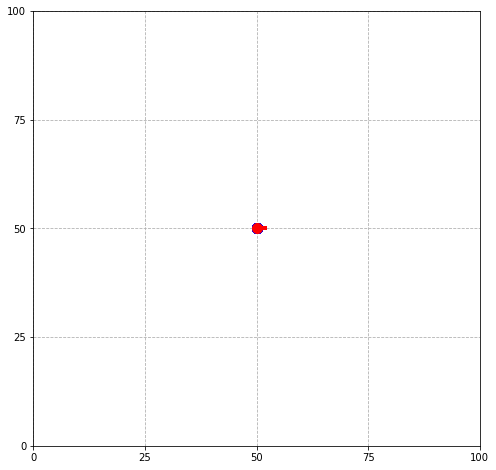

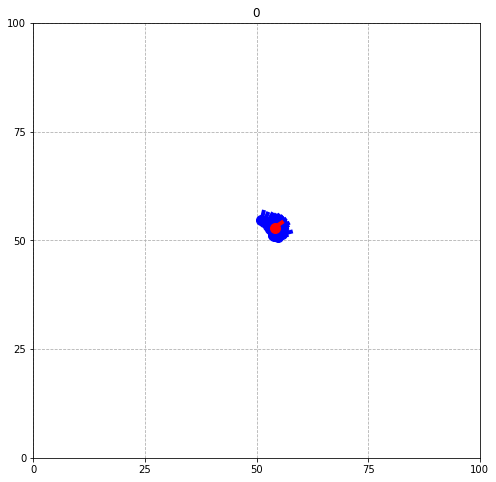

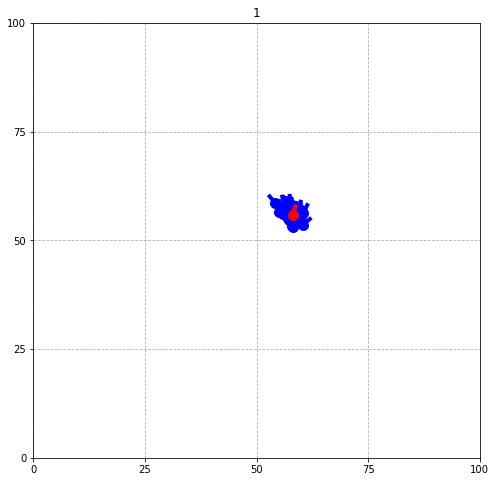

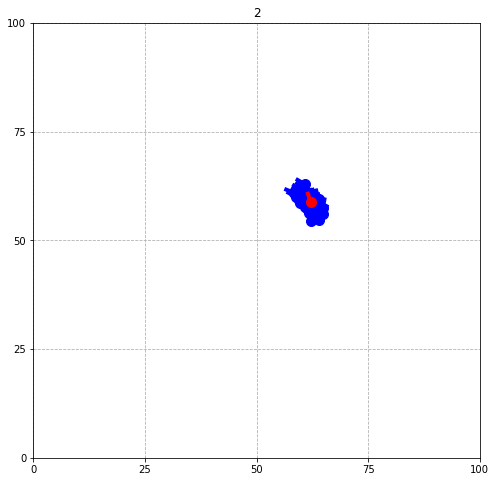

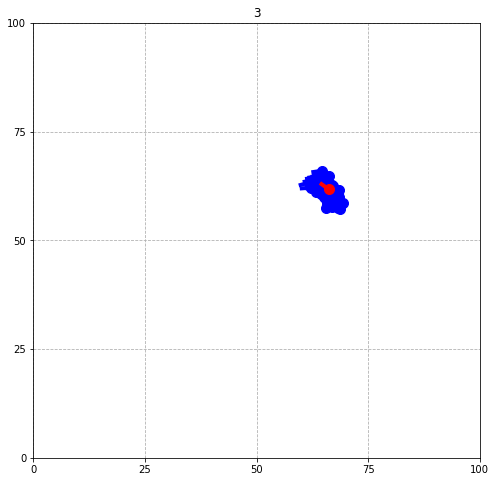

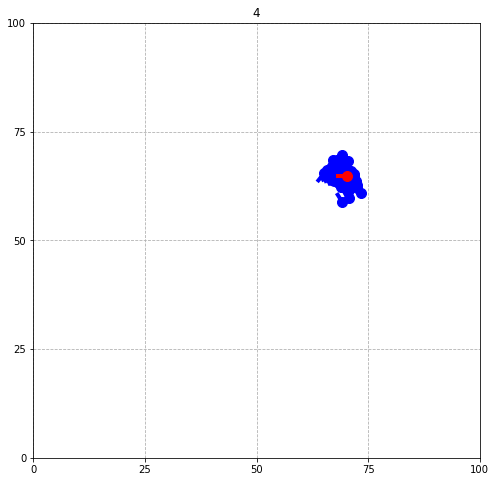

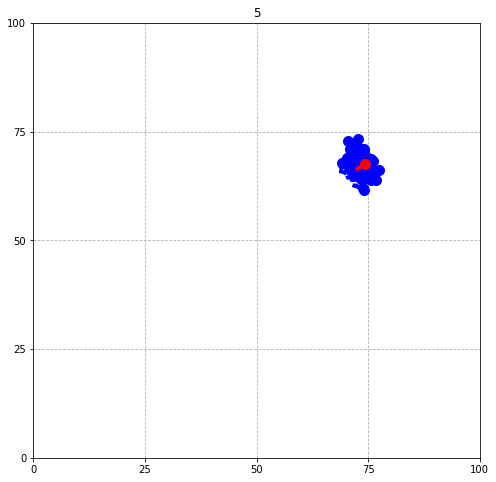

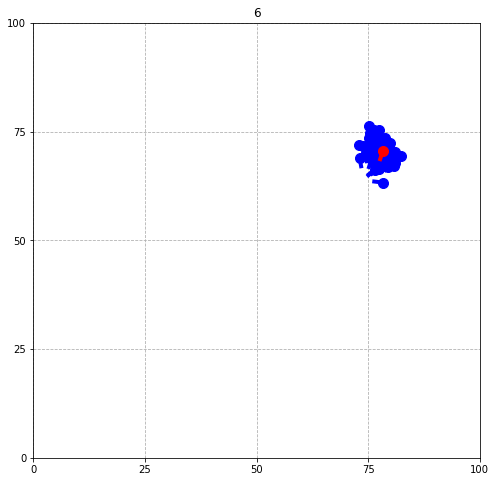

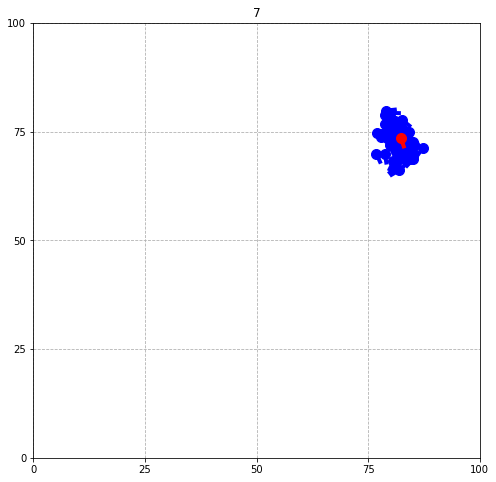

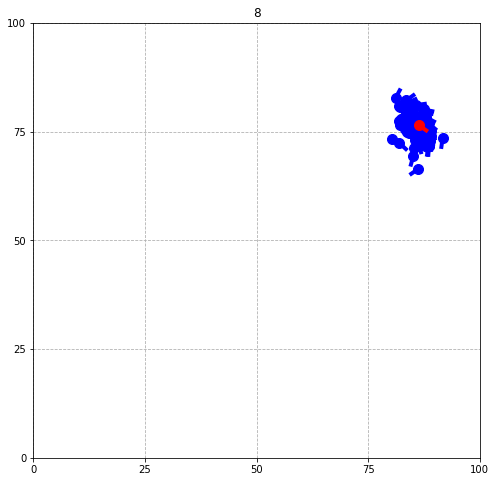

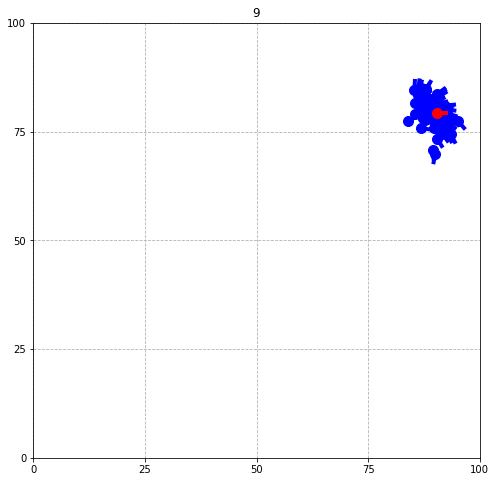

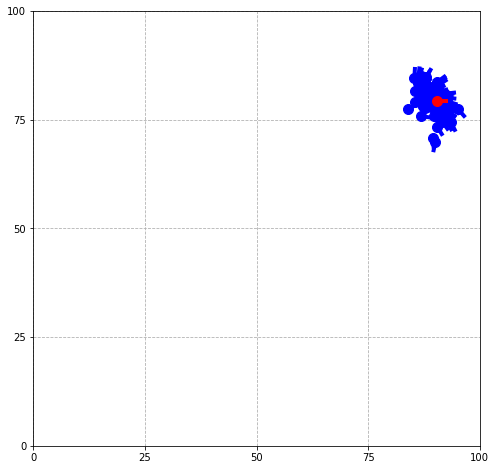

In [2]:
from sim.plot2d import plot
import random as r
import math

robot = Robot([50, 50, 0])
particles = []
for i in range(100):
    particles += [Particle([50, 50, 0])]
plot(robot, particles)

autorun = True
for j in range(10):
    robot.move(5, math.pi * 2 / 10)
    for particle in particles:
        particle.predict(5, math.pi * 2 / 10)
    plot(robot, particles, j=j, autorun=autorun)

plot(robot, particles)


# assignment4-2

Robot Measurements:
Distance: 56.6 Angle: 0.79
Distance: 30.0 Angle: 0.0
Distance: 20.0 Angle: 1.57
Distance: 25.0 Angle: 3.14

Measurement Answers:
Distance: 56.6 Angle: 0.79
Distance: 30.0 Angle: 0.0
Distance: 20.0 Angle: 1.57
Distance: 25.0 Angle: 3.14


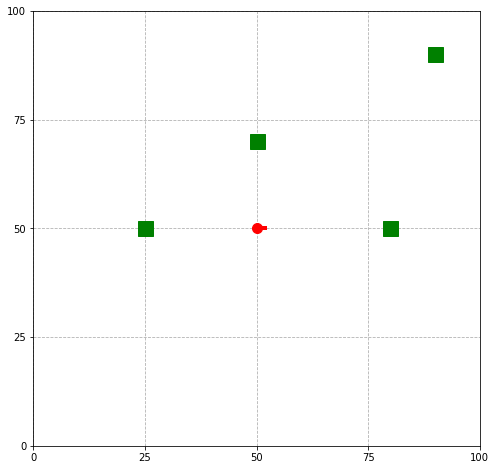

In [3]:
from sim.plot2d import plot
import random as r
import math


robot = Robot([50, 50, 0])
poles = [Pole([90, 90, 0]), Pole([80, 50, 0]),
         Pole([50, 70, 0]), Pole([25, 50, 0])]


print("Robot Measurements:")
robot.measure(poles)
for measurement in robot.measurements:
    print("Distance: " + str(round(measurement.distance, 1)) +
          " Angle: " + str(round(measurement.angle, 2)))

print()
print("Measurement Answers:")
print("Distance: 56.6 Angle: 0.79")
print("Distance: 30.0 Angle: 0.0")
print("Distance: 20.0 Angle: 1.57")
print("Distance: 25.0 Angle: 3.14")
plot(robot, poles=poles)


# assignment4-3

Weight: 1.0
Measurements: 35.36
Measurements: 25.0
Weight: 0.54
Measurements: 35.36
Measurements: 25.0
Weight: 0.0
Measurements: 70.71
Measurements: 55.9
Weight: 0.12
Measurements: 42.43
Measurements: 30.41
Weight: 0.25
Measurements: 22.36
Measurements: 25.0

Answers:
Weight: 1.0
Weight: 0.54
Weight: 0.0
Weight: 0.12
Weight: 0.25


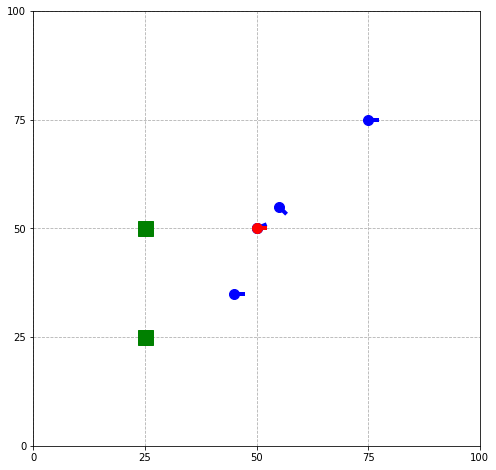

In [4]:
from sim.plot2d import plot
import random as r
import math

robot = Robot([50, 50, 0])
poles = [Pole([25, 25, 0])]
# Probably comment for real assignment.
poles += [Pole([25, 50, 0])]
particles = []
particles += [Particle([50, 50, 0])]
particles += [Particle([50, 50, math.pi / 8])]
particles += [Particle([75, 75, 0])]
particles += [Particle([55, 55, -math.pi / 4])]
particles += [Particle([45, 35, 0])]

robot.measure(poles)
for particle in particles:
    particle.measure(poles)
    particle.update_weight(robot.measurements)
    print("Weight: " + str(round(particle.weight, 2)))
    for measure in particle.measurements:
        print("Measurements: " + str(round(measure.distance, 2)))

print()
print("Answers:")
print("Weight: 1.0")
print("Weight: 0.54")
print("Weight: 0.0")
print("Weight: 0.12")
print("Weight: 0.25")
plot(robot, particles, poles)

# assignment4-4

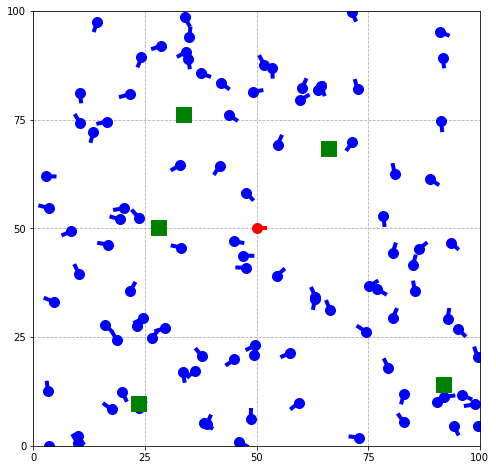

Error: [8.1, 0.18]
Weight Sum: 3.66
Max Weight: 0.47


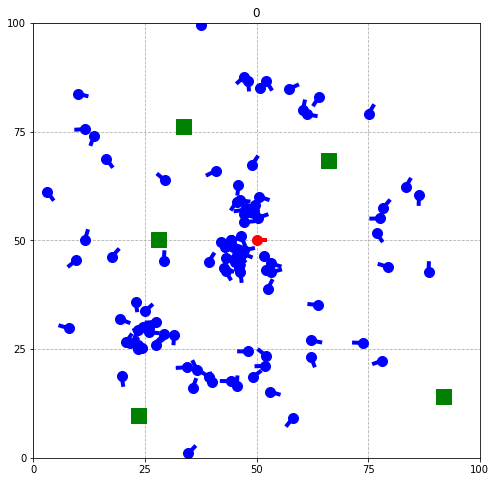

Error: [5.1, 0.22]
Weight Sum: 9.7
Max Weight: 0.61


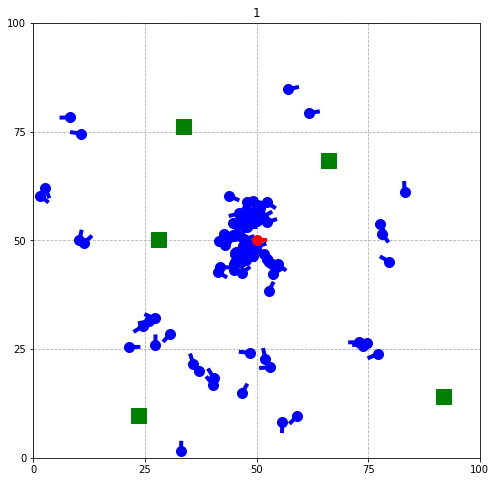

Error: [5.2, 0.07]
Weight Sum: 21.23
Max Weight: 0.74


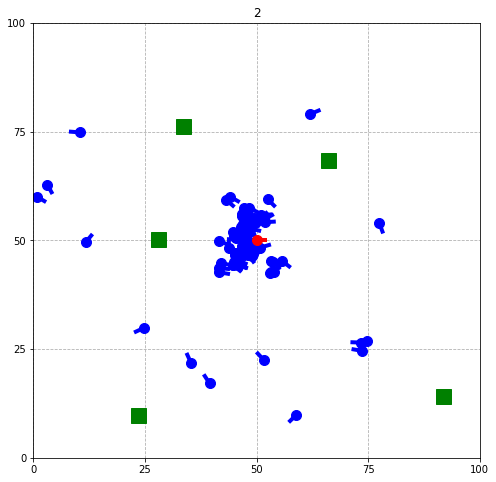

Error: [3.7, 0.02]
Weight Sum: 34.5
Max Weight: 0.86


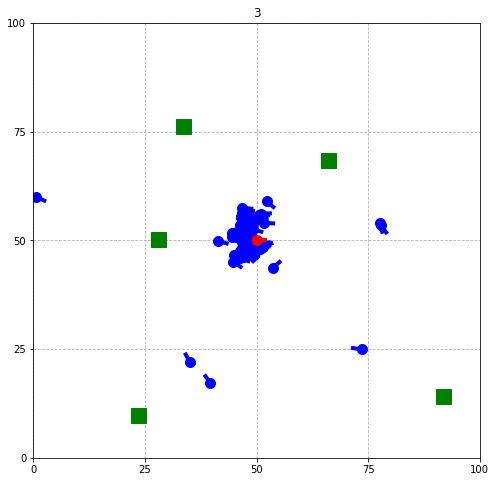

Error: [3.0, 0.03]
Weight Sum: 49.46
Max Weight: 0.9


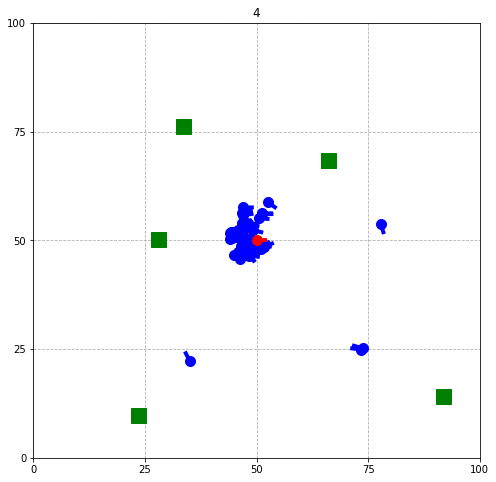

Error: [1.3, 0.1]
Weight Sum: 56.26
Max Weight: 0.94
Converged!


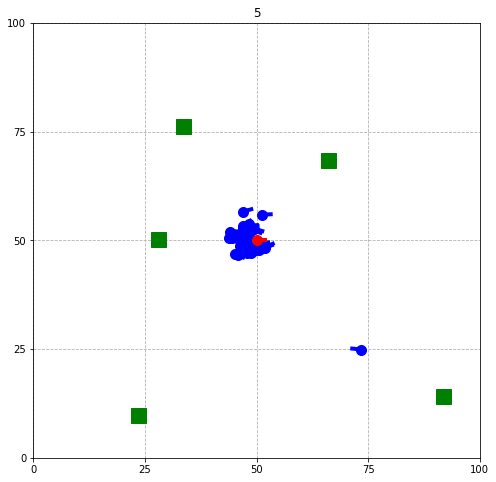

Error: [1.3, 0.14]
Weight Sum: 64.16
Max Weight: 0.91
Converged!


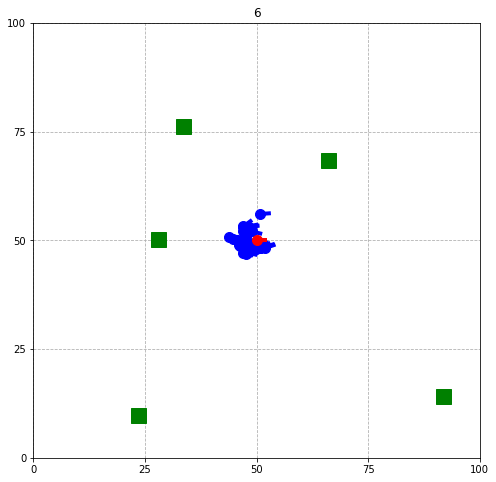

Error: [1.5, 0.14]
Weight Sum: 67.87
Max Weight: 0.89
Converged!


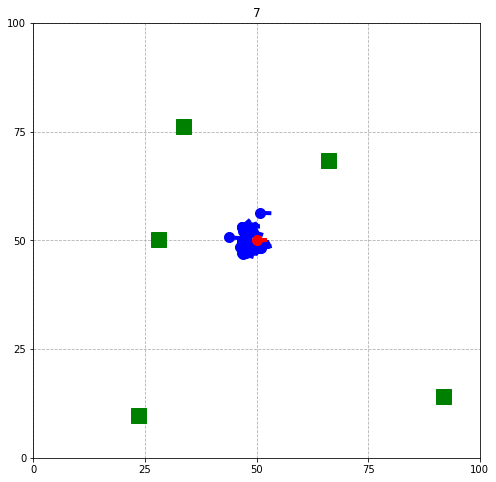

Error: [2.3, 0.1]
Weight Sum: 70.23
Max Weight: 0.9
Converged!


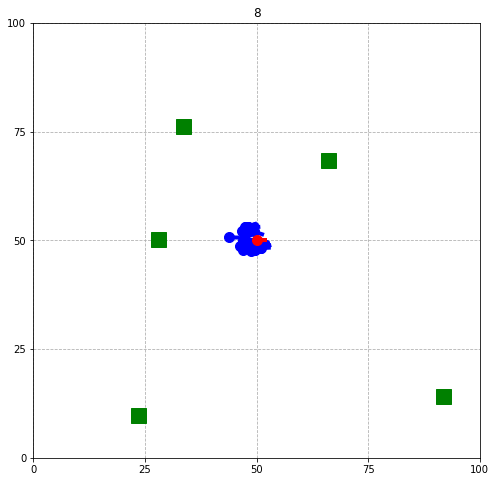

Error: [2.1, 0.06]
Weight Sum: 72.31
Max Weight: 0.93
Converged!


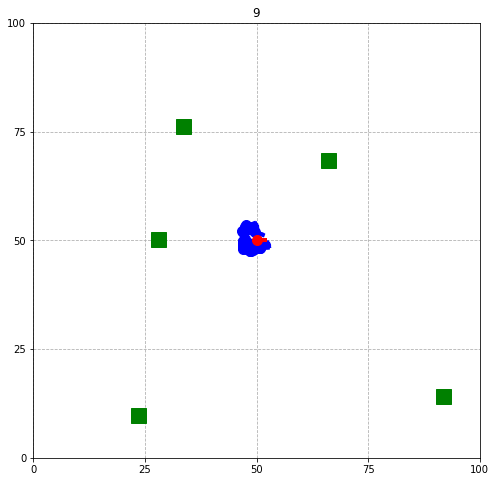

Error: [2.6, 0.0]
Weight Sum: 73.04
Max Weight: 0.93
Converged!


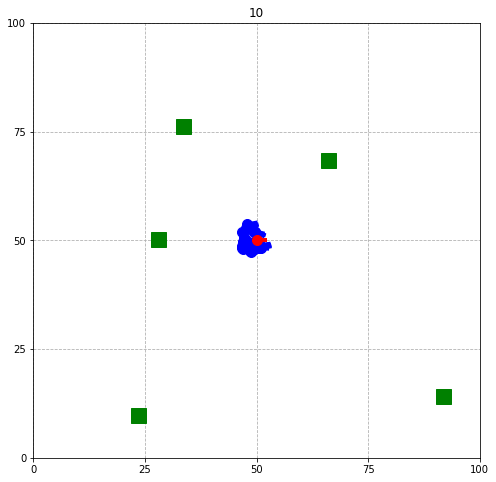

Error: [2.6, 0.03]
Weight Sum: 74.65
Max Weight: 0.92
Converged!


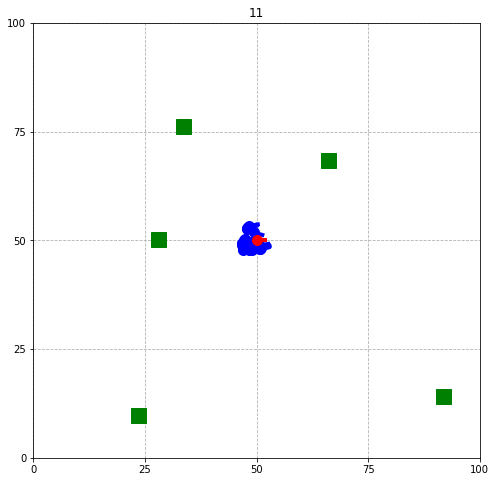

Error: [2.2, 0.01]
Weight Sum: 76.75
Max Weight: 0.95
Converged!


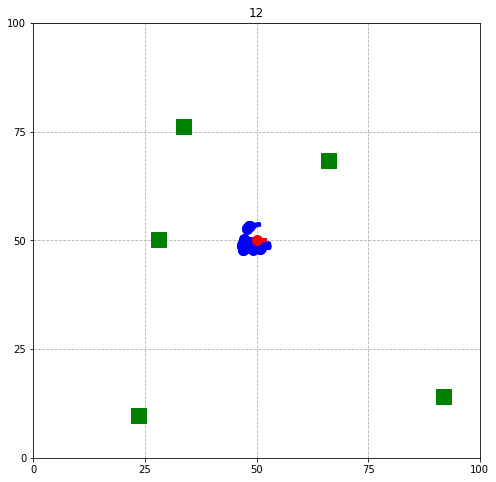

Error: [2.2, 0.01]
Weight Sum: 77.9
Max Weight: 0.95
Converged!


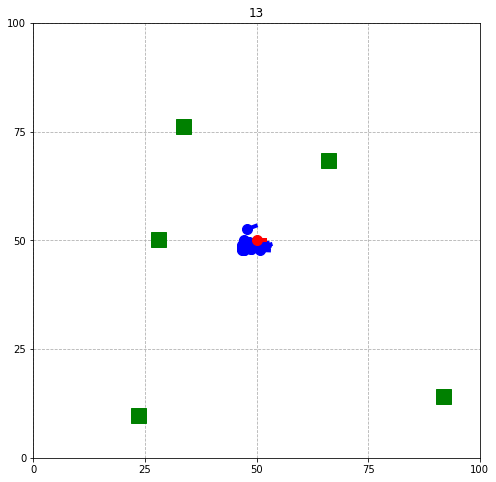

Error: [1.9, 0.01]
Weight Sum: 78.94
Max Weight: 0.96
Converged!


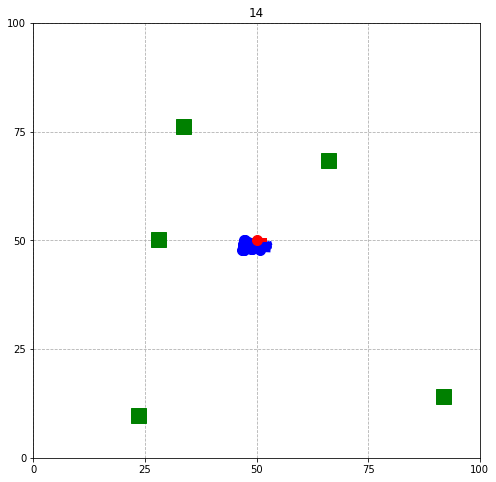

Error: [2.3, 0.07]
Weight Sum: 80.01
Max Weight: 0.93
Converged!


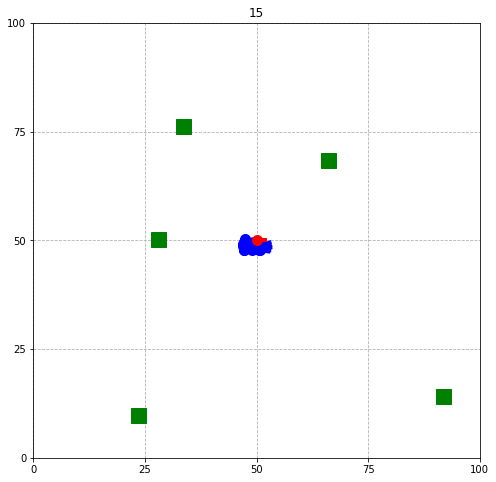

Error: [1.3, 0.06]
Weight Sum: 82.07
Max Weight: 0.96
Converged!


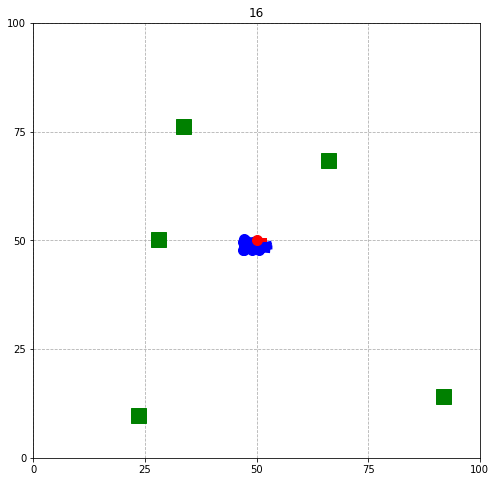

Error: [1.2, 0.06]
Weight Sum: 81.17
Max Weight: 0.96
Converged!


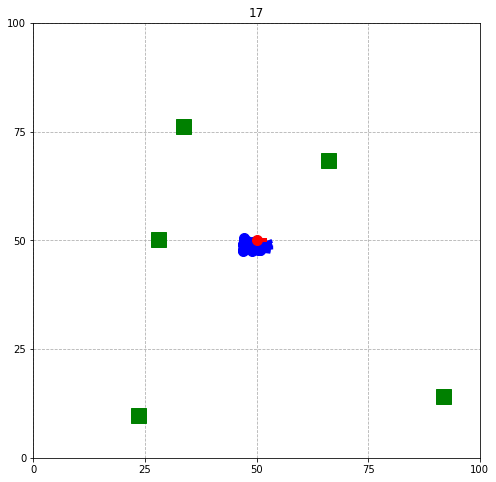

Error: [1.3, 0.06]
Weight Sum: 81.44
Max Weight: 0.96
Converged!


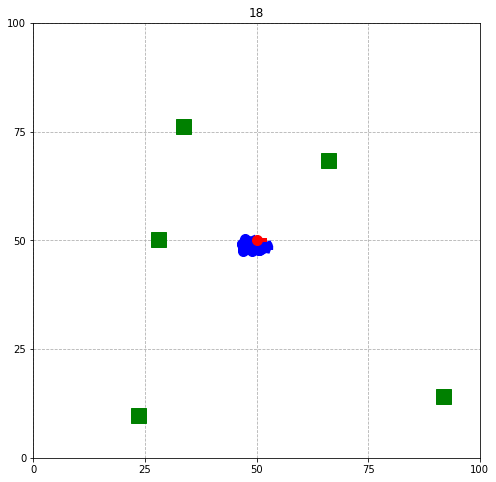

Error: [1.2, 0.0]
Weight Sum: 81.24
Max Weight: 0.98
Converged!


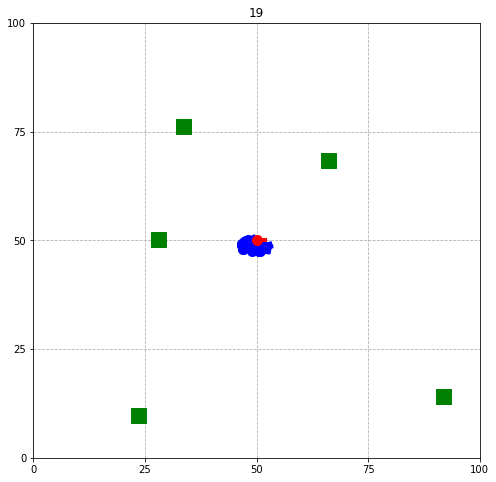

In [5]:
from sim.plot2d import plot, print_particle_error
import random as r
import math


r.seed(939)
robot = Robot([50, 50, 0])
poles = []
num_poles = 5
for i in range(num_poles):
    x = r.uniform(0, 100)
    y = r.uniform(0, 100)
    poles += [Pole([x, y, 0])]
particles = []
num_particles = 100
for i in range(num_particles):
    x = r.uniform(0, 100)
    y = r.uniform(0, 100)
    theta = r.uniform(0, math.pi * 2)
    particles += [Particle([x, y, theta])]

plot(robot, particles, poles)

robot.measure(poles)
for i in range(20):
    for particle in particles:
        particle.measure(poles)
        particle.update_weight(robot.measurements)
    print_particle_error(robot, particles)
    particles = resample_particles(particles)
    plot(robot, particles, poles, j=i, autorun=True)


# assignment4-5

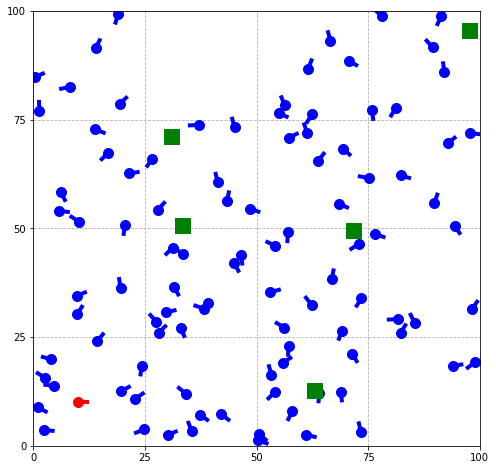

Error: [118.4, 3.0]
Weight Sum: 2.29
Max Weight: 0.15


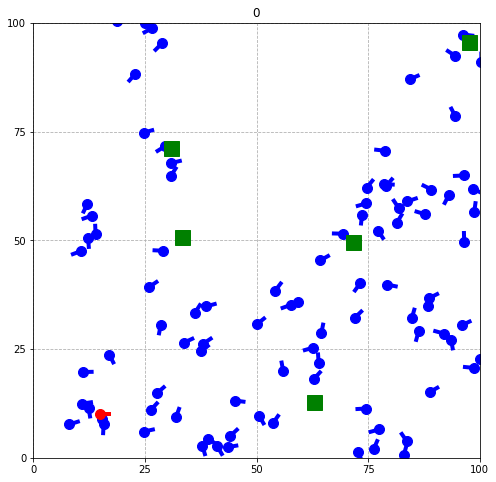

Error: [5.0, 0.03]
Weight Sum: 5.73
Max Weight: 0.86


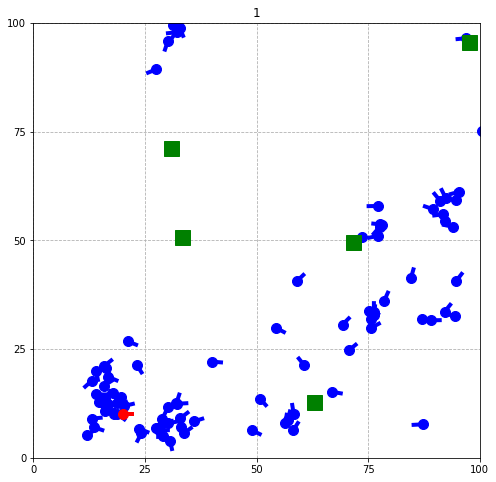

Error: [4.2, 0.08]
Weight Sum: 14.17
Max Weight: 0.92


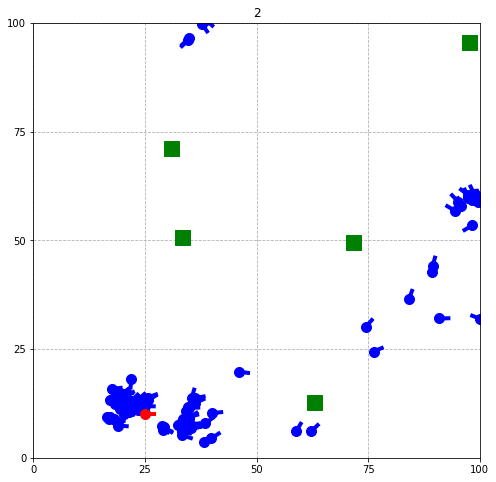

Error: [2.8, 0.08]
Weight Sum: 29.44
Max Weight: 0.93
Converged!


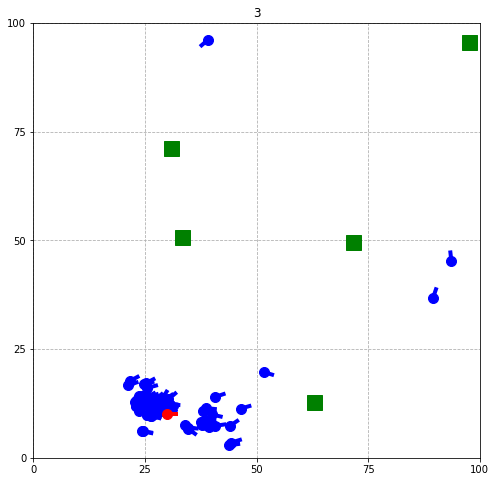

Error: [3.1, 0.12]
Weight Sum: 43.81
Max Weight: 0.9


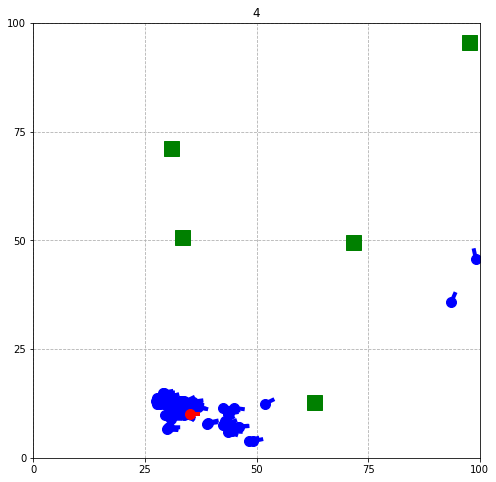

Error: [2.6, 0.06]
Weight Sum: 50.94
Max Weight: 0.92
Converged!


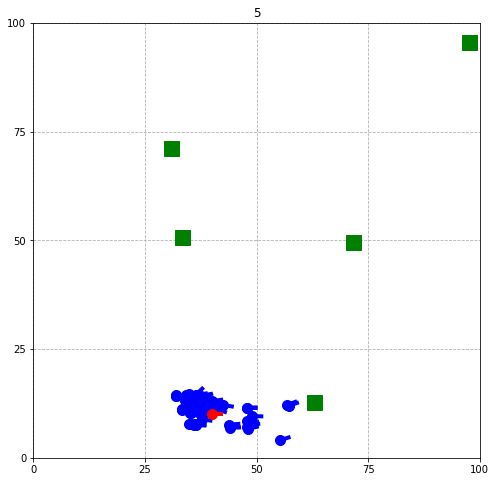

Error: [2.4, 0.11]
Weight Sum: 53.86
Max Weight: 0.94
Converged!


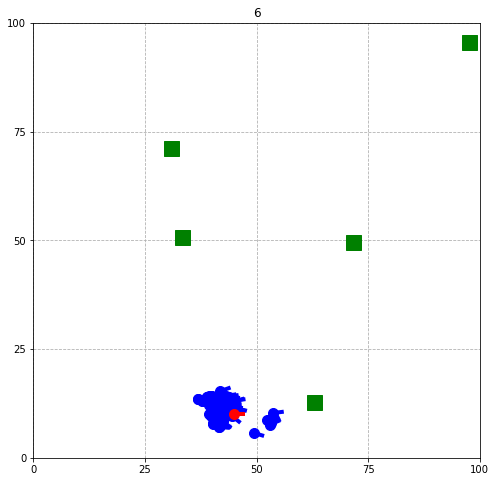

Error: [3.2, 0.04]
Weight Sum: 49.76
Max Weight: 0.92


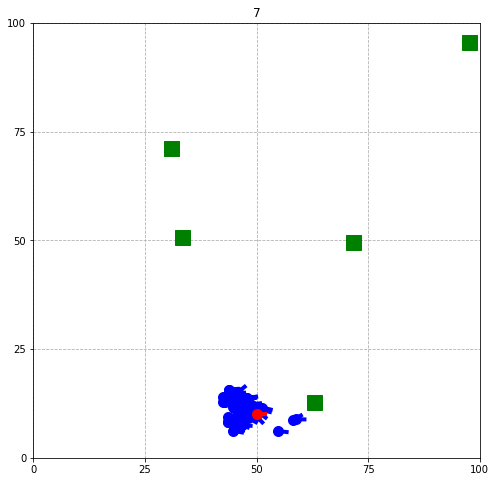

Error: [2.7, 0.04]
Weight Sum: 54.76
Max Weight: 0.93
Converged!


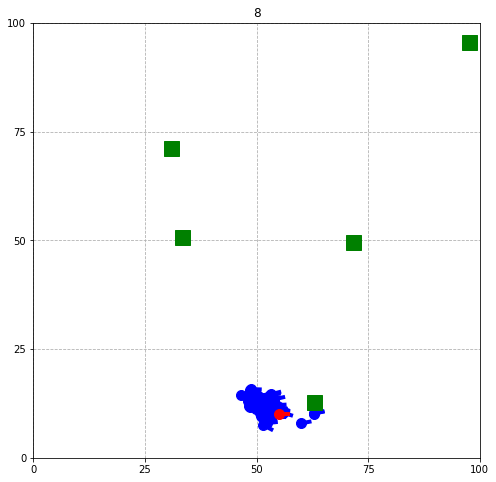

Error: [2.0, 0.16]
Weight Sum: 47.15
Max Weight: 0.9
Converged!


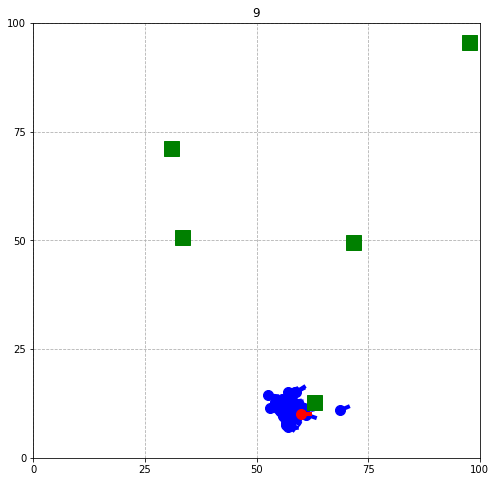

Error: [1.8, 0.1]
Weight Sum: 42.2
Max Weight: 0.93
Converged!


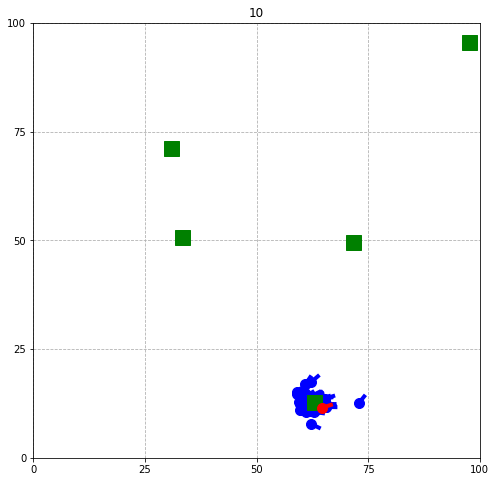

Error: [1.1, 0.01]
Weight Sum: 57.14
Max Weight: 0.99
Converged!


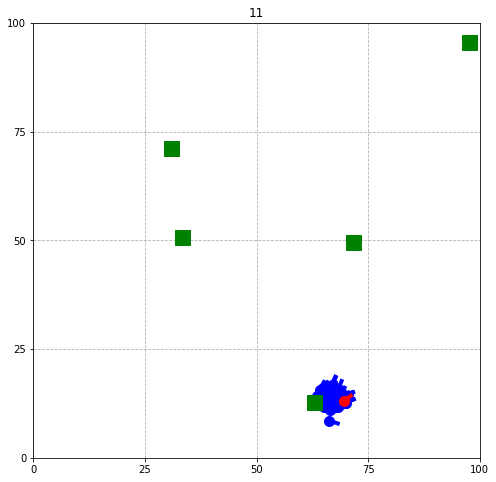

Error: [0.4, 0.1]
Weight Sum: 59.15
Max Weight: 0.96
Converged!


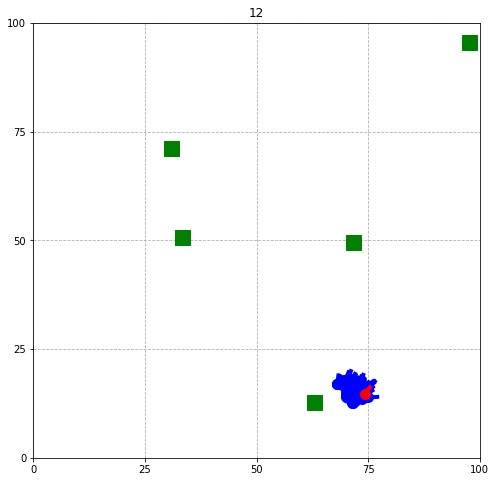

Error: [1.1, 0.04]
Weight Sum: 64.45
Max Weight: 0.97
Converged!


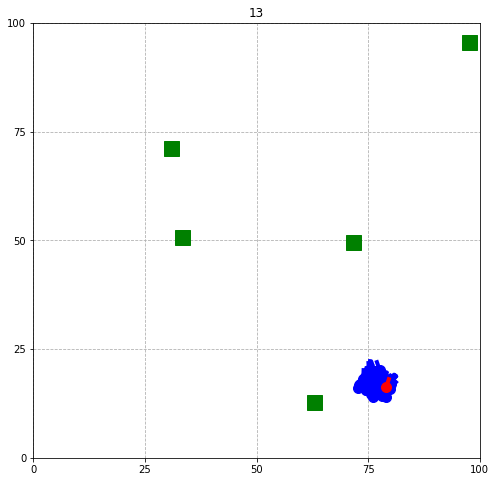

Error: [1.7, 0.03]
Weight Sum: 64.0
Max Weight: 0.97
Converged!


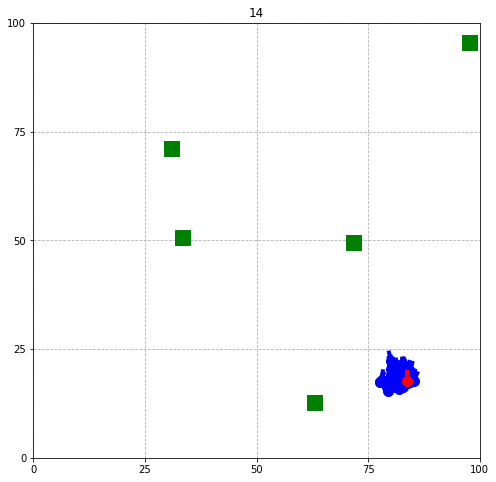

Error: [0.8, 0.05]
Weight Sum: 62.05
Max Weight: 0.98
Converged!


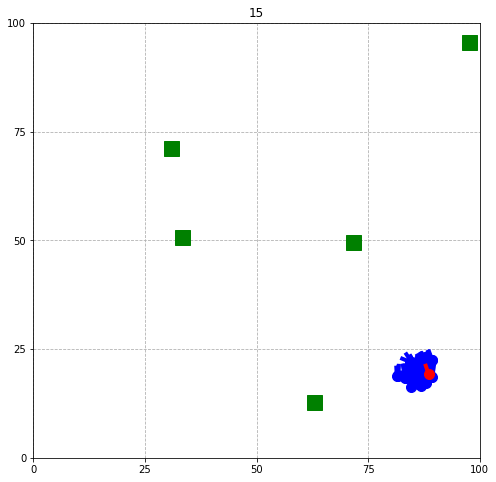

Error: [1.6, 0.01]
Weight Sum: 62.92
Max Weight: 0.99
Converged!


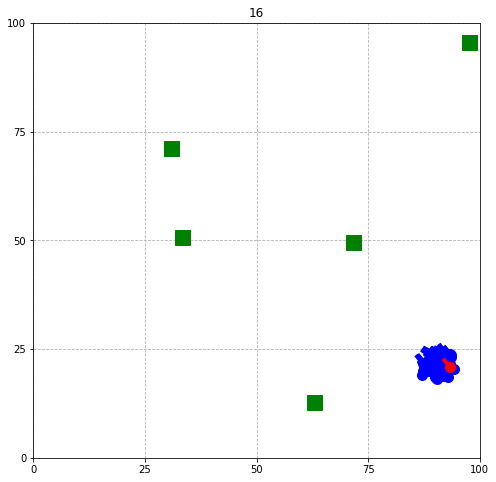

Error: [0.8, 0.04]
Weight Sum: 64.18
Max Weight: 0.98
Converged!


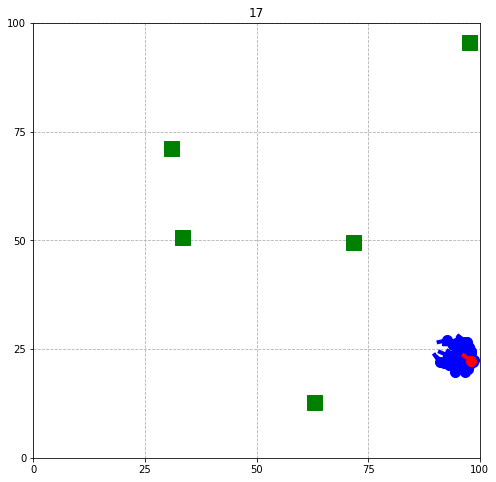

Error: [1.4, 0.04]
Weight Sum: 59.3
Max Weight: 0.98
Converged!


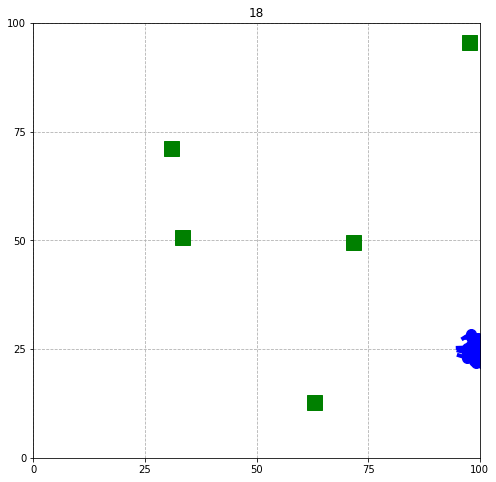

Error: [1.8, 0.02]
Weight Sum: 53.58
Max Weight: 0.98
Converged!


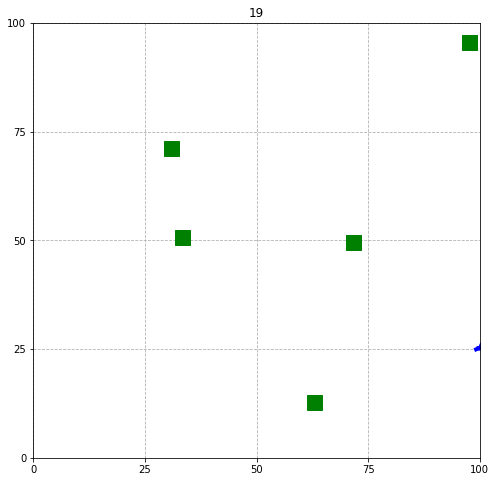

Error: [0.1, 0.07]
Weight Sum: 58.37
Max Weight: 0.98
Converged!


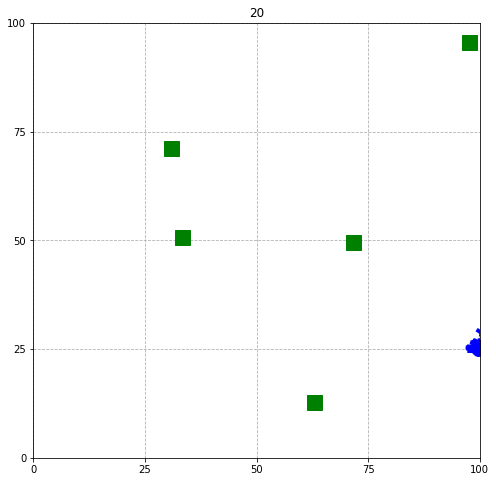

Error: [2.3, 0.02]
Weight Sum: 62.96
Max Weight: 0.96
Converged!


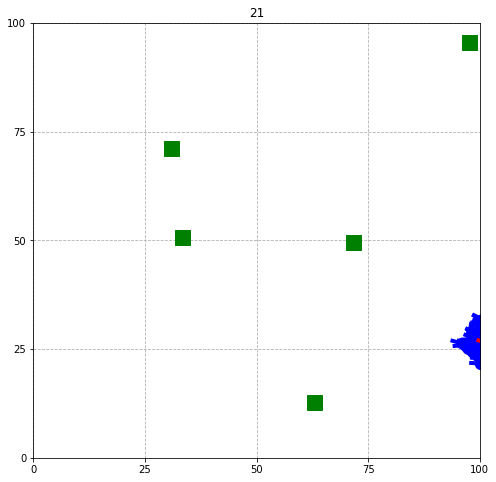

Error: [0.8, 0.0]
Weight Sum: 63.49
Max Weight: 0.99
Converged!


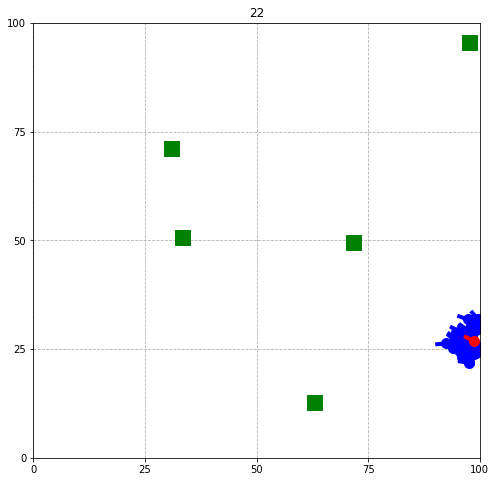

Error: [0.5, 0.09]
Weight Sum: 63.7
Max Weight: 0.96
Converged!


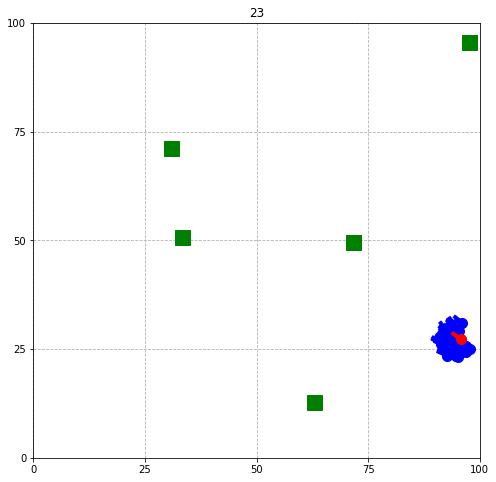

Error: [0.7, 0.12]
Weight Sum: 63.33
Max Weight: 0.93
Converged!


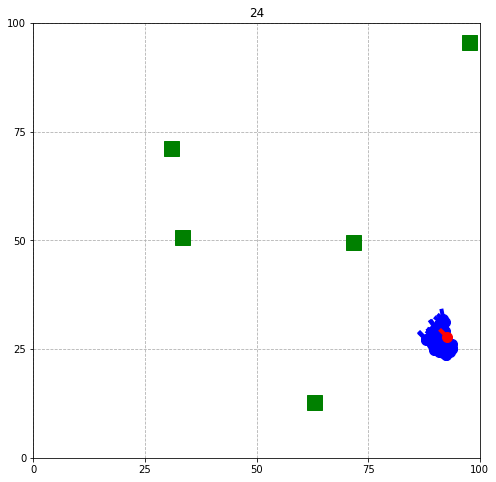

Error: [1.2, 0.06]
Weight Sum: 59.87
Max Weight: 0.97
Converged!


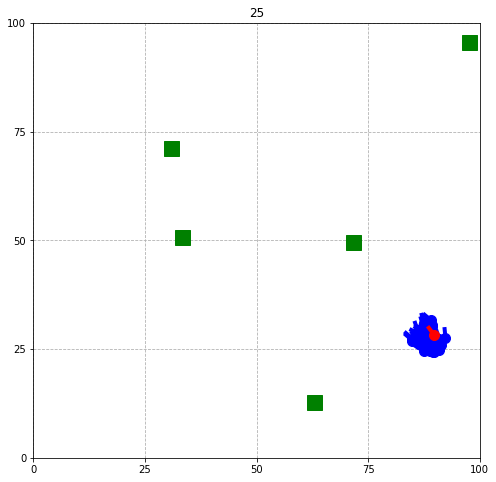

Error: [0.8, 0.04]
Weight Sum: 64.51
Max Weight: 0.99
Converged!


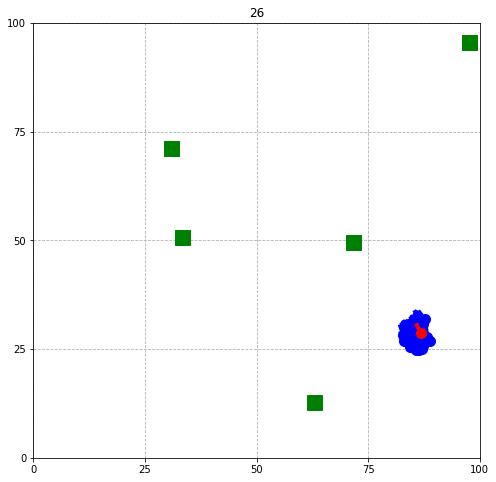

Error: [1.1, 0.04]
Weight Sum: 64.03
Max Weight: 0.96
Converged!


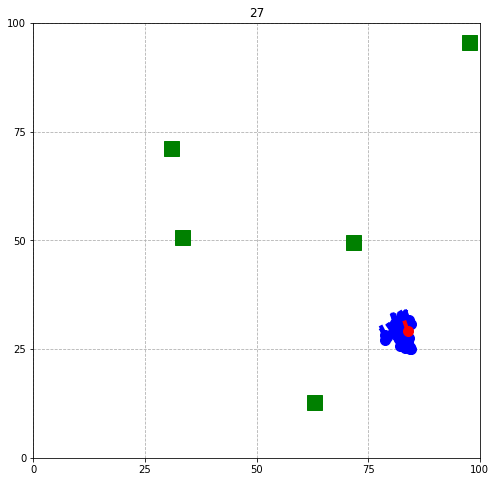

Error: [0.6, 0.07]
Weight Sum: 61.47
Max Weight: 0.98
Converged!


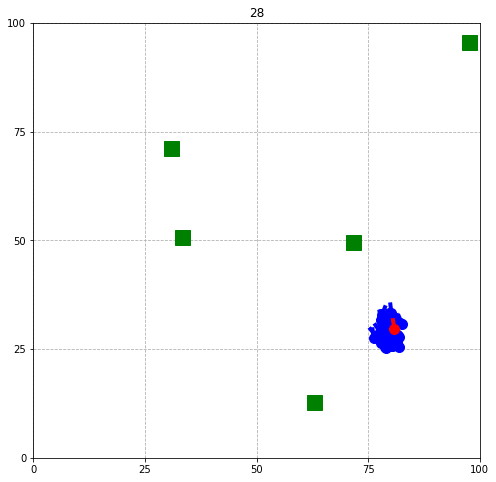

Error: [0.9, 0.07]
Weight Sum: 61.98
Max Weight: 0.98
Converged!


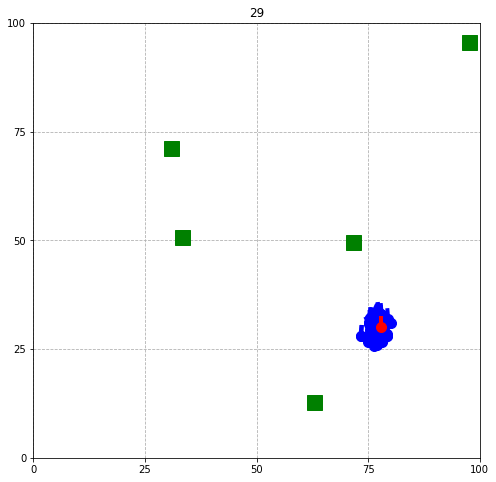

Error: [1.0, 0.02]
Weight Sum: 63.38
Max Weight: 0.99
Converged!


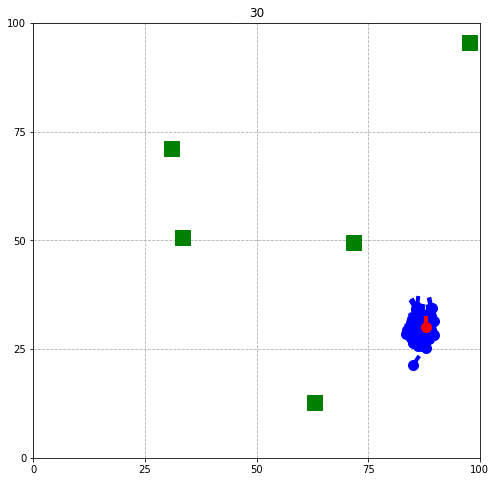

Error: [0.9, 0.02]
Weight Sum: 64.33
Max Weight: 0.99
Converged!


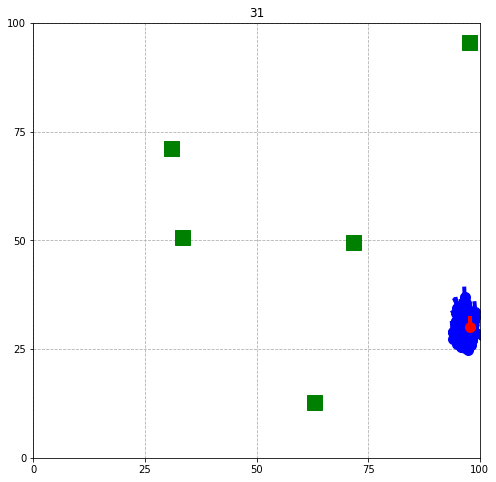

Error: [0.7, 0.06]
Weight Sum: 67.03
Max Weight: 0.98
Converged!


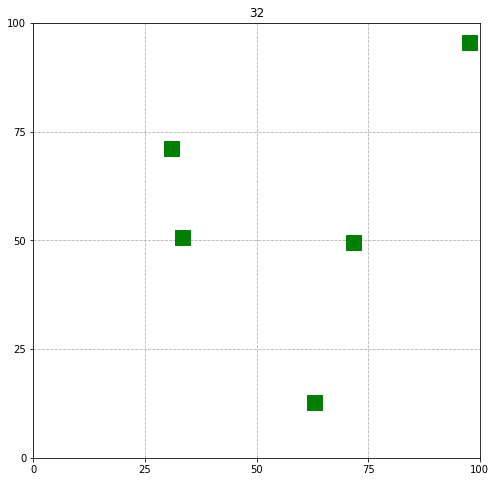

Error: [1.0, 0.05]
Weight Sum: 63.89
Max Weight: 0.98
Converged!


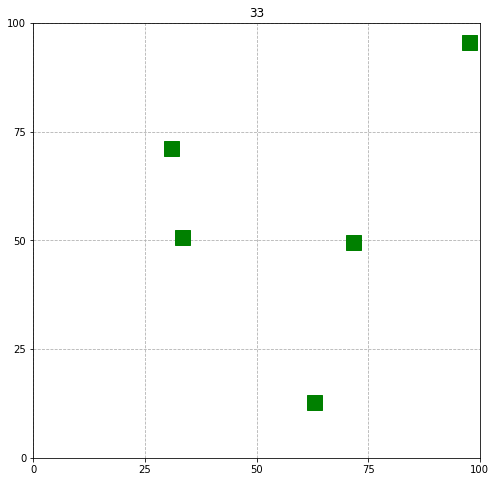

Error: [1.2, 0.01]
Weight Sum: 64.43
Max Weight: 0.99
Converged!


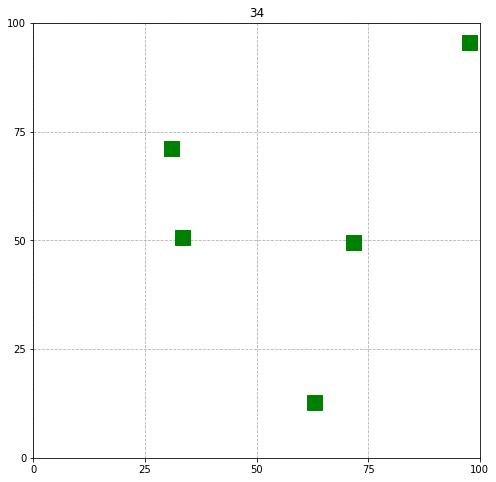

Error: [0.7, 0.04]
Weight Sum: 64.71
Max Weight: 0.99
Converged!


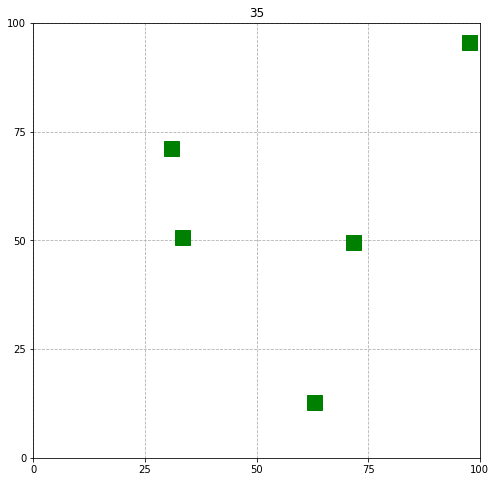

Error: [0.6, 0.08]
Weight Sum: 64.47
Max Weight: 0.97
Converged!


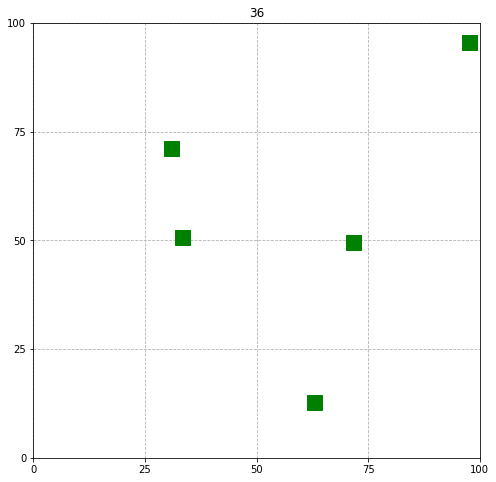

Error: [2.5, 0.03]
Weight Sum: 67.17
Max Weight: 0.97
Converged!


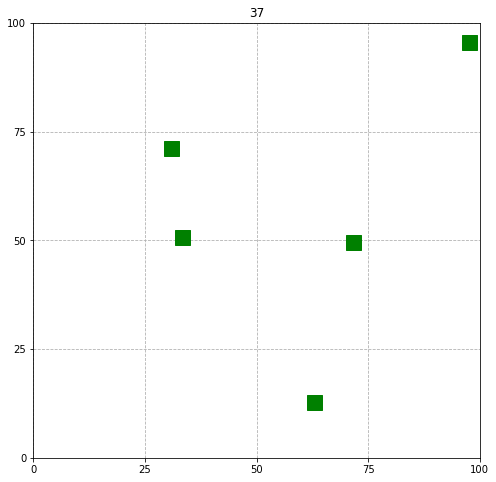

Error: [0.7, 0.04]
Weight Sum: 67.67
Max Weight: 0.99
Converged!


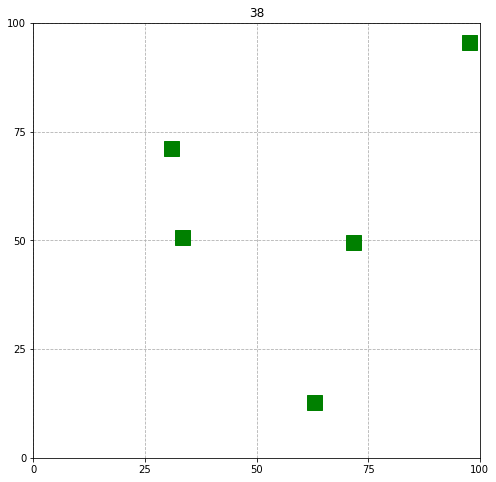

Error: [1.3, 0.02]
Weight Sum: 65.78
Max Weight: 0.98
Converged!


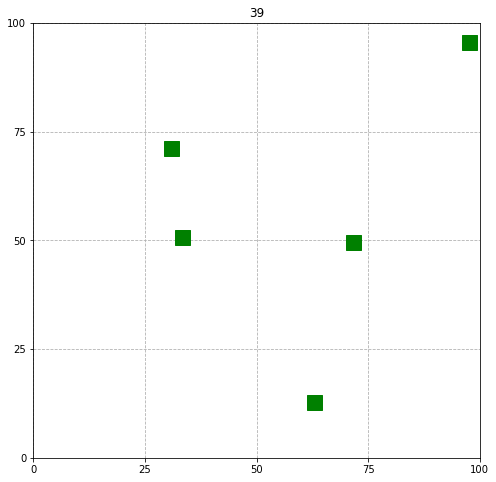

Error: [0.8, 0.02]
Weight Sum: 66.64
Max Weight: 1.0
Converged!


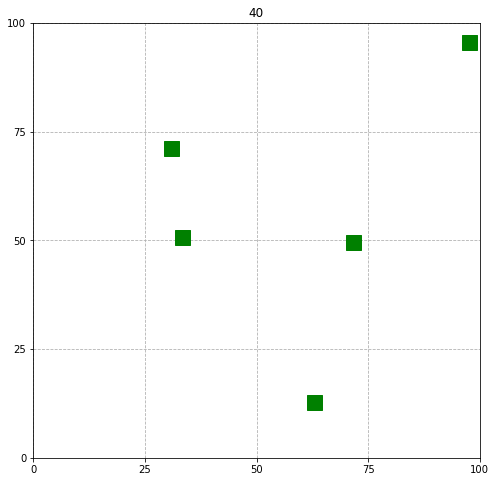

Error: [1.5, 0.05]
Weight Sum: 65.37
Max Weight: 0.98
Converged!


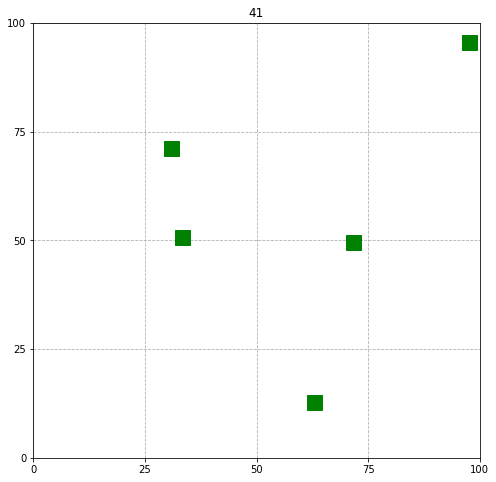

Error: [1.5, 0.01]
Weight Sum: 65.13
Max Weight: 0.98
Converged!


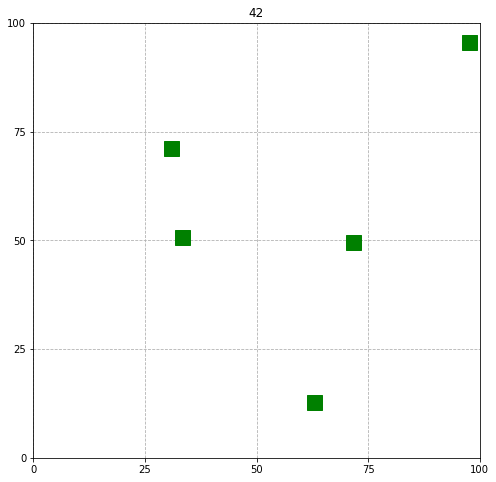

Error: [2.2, 0.06]
Weight Sum: 65.85
Max Weight: 0.98
Converged!


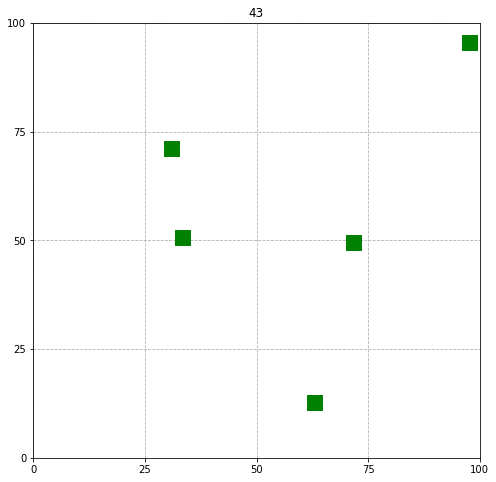

Error: [2.7, 0.03]
Weight Sum: 64.27
Max Weight: 0.97
Converged!


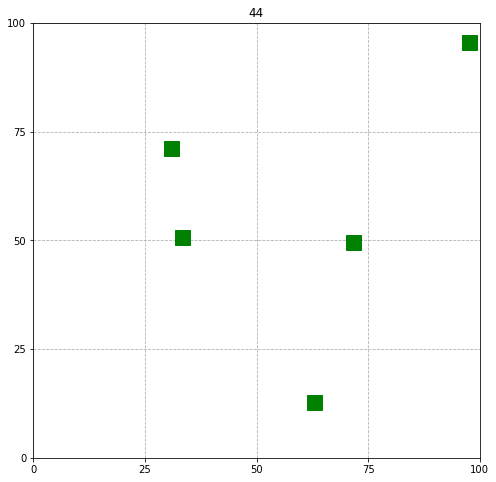

Error: [0.6, 0.0]
Weight Sum: 64.75
Max Weight: 0.99
Converged!


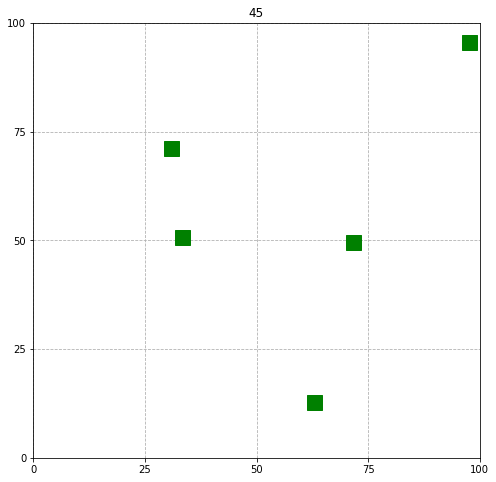

Error: [0.3, 0.01]
Weight Sum: 66.21
Max Weight: 1.0
Converged!


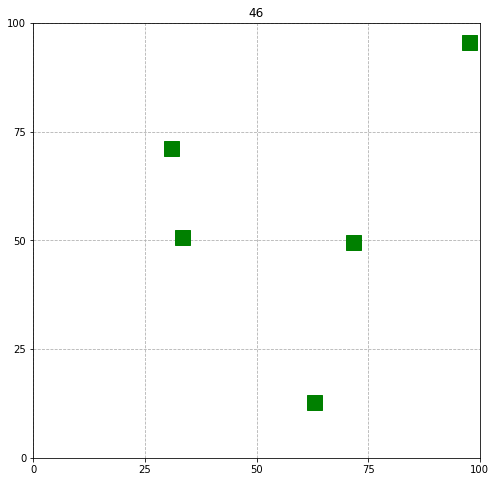

Error: [1.3, 0.0]
Weight Sum: 66.72
Max Weight: 0.99
Converged!


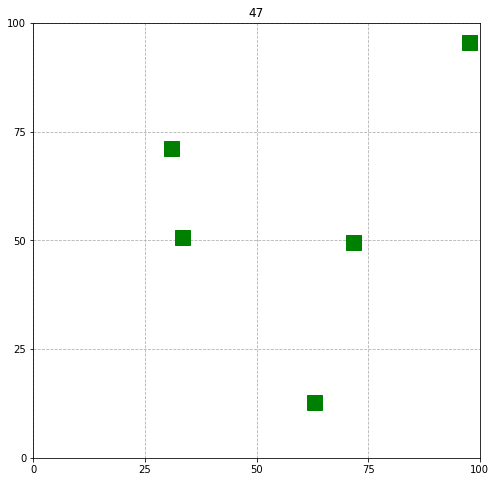

Error: [1.0, 0.01]
Weight Sum: 68.89
Max Weight: 0.99
Converged!


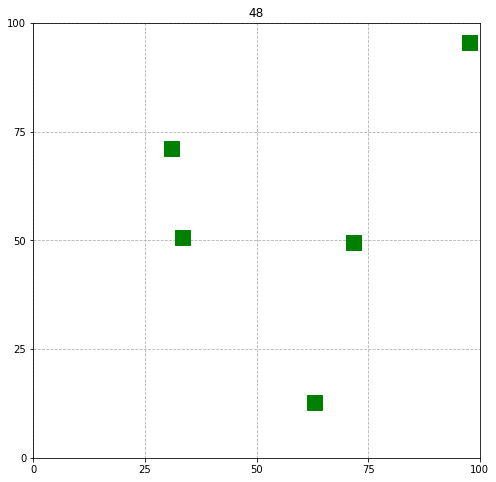

Error: [0.4, 0.01]
Weight Sum: 68.51
Max Weight: 1.0
Converged!


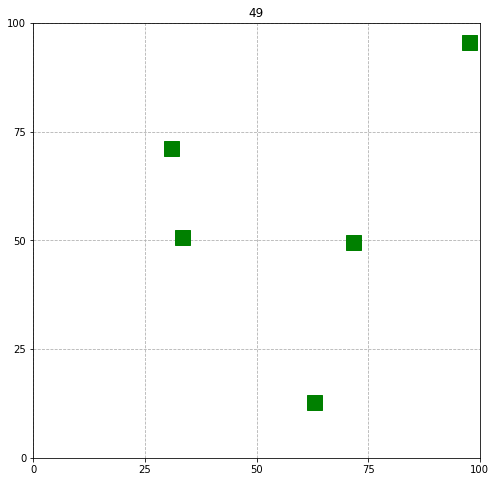

Error: [1.4, 0.0]
Weight Sum: 65.31
Max Weight: 1.0
Converged!


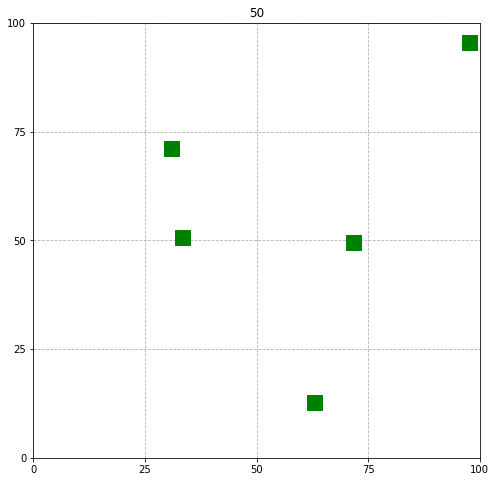

Error: [0.1, 0.06]
Weight Sum: 68.93
Max Weight: 0.99
Converged!


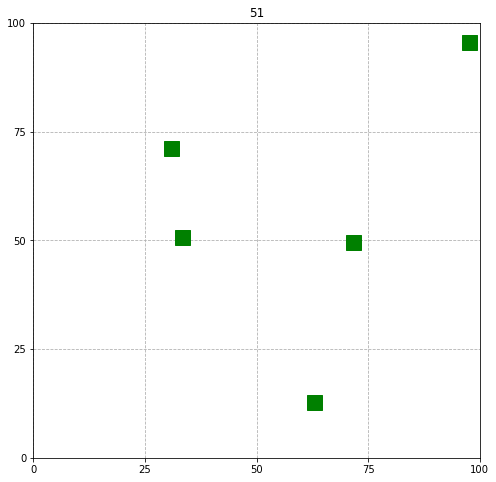

Error: [0.6, 0.02]
Weight Sum: 68.44
Max Weight: 1.0
Converged!


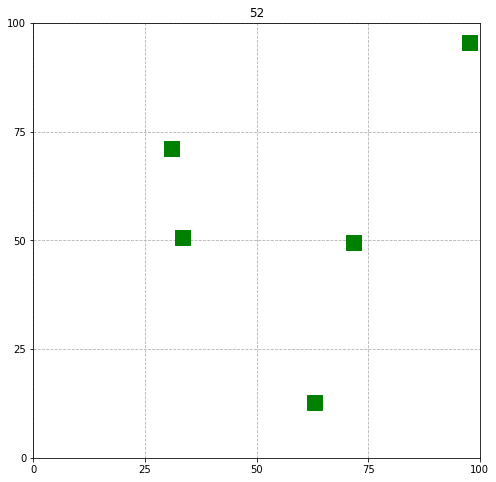

Error: [0.6, 0.06]
Weight Sum: 66.78
Max Weight: 0.98
Converged!


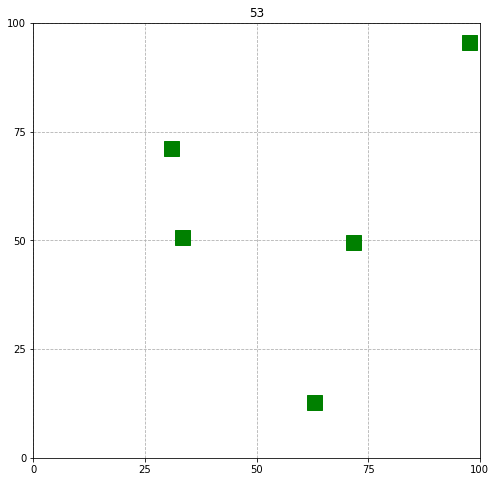

Error: [1.8, 0.04]
Weight Sum: 70.08
Max Weight: 0.99
Converged!


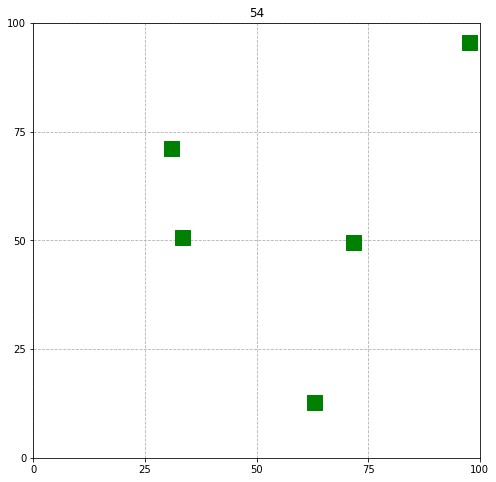

Error: [1.4, 0.03]
Weight Sum: 68.26
Max Weight: 0.99
Converged!


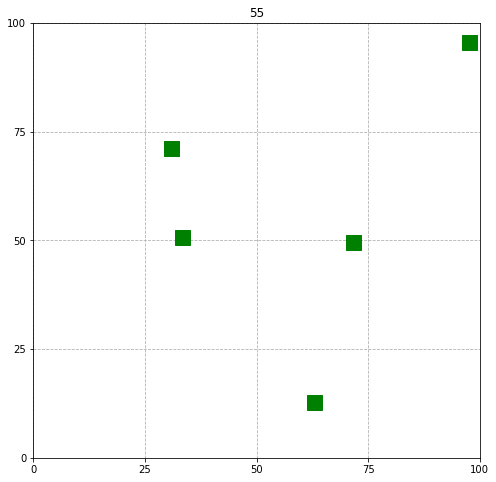

Error: [0.4, 0.07]
Weight Sum: 68.77
Max Weight: 0.98
Converged!


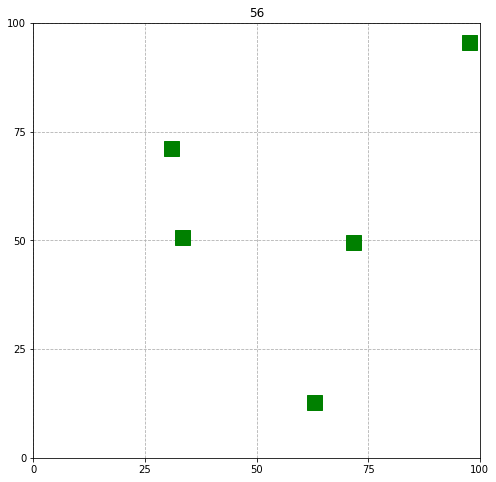

Error: [1.6, 0.01]
Weight Sum: 65.11
Max Weight: 1.0
Converged!


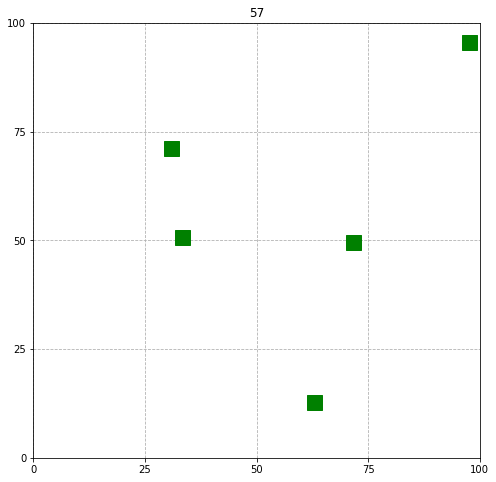

Error: [1.6, 0.02]
Weight Sum: 67.39
Max Weight: 0.99
Converged!


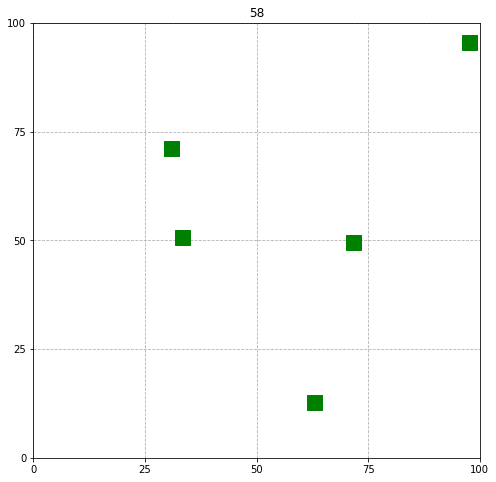

Error: [1.3, 0.04]
Weight Sum: 64.26
Max Weight: 0.99
Converged!


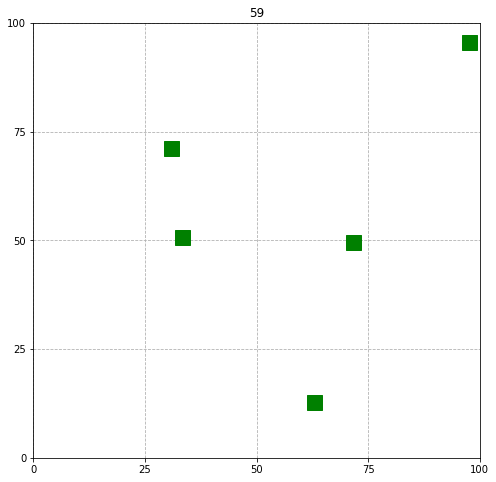

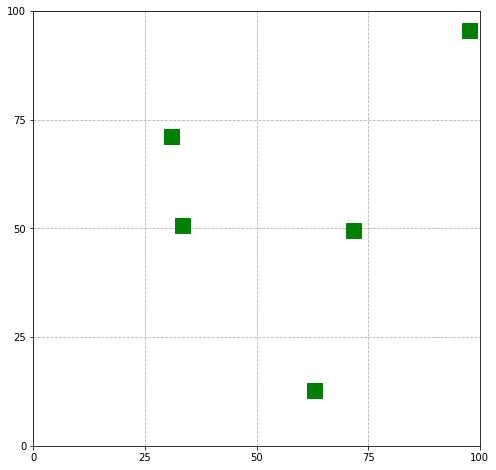

In [6]:
from sim.plot2d import plot, print_particle_error
import random as r
import math


# r.seed(939)
robot = Robot([10, 10, 0])
poles = []
num_poles = 5
for i in range(num_poles):
    x = r.uniform(0, 100)
    y = r.uniform(0, 100)
    poles += [Pole([x, y, 0])]
particles = []
num_particles = 100
for i in range(num_particles):
    x = r.uniform(0, 100)
    y = r.uniform(0, 100)
    theta = r.uniform(0, math.pi * 2)
    particles += [Particle([x, y, theta])]

plot(robot, particles, poles)


moves = []
for i in range(60):
    if i < 10:
        moves += [[5, 0]]
        continue
    if i < 20:
        moves += [[5, math.pi / 10]]
        continue
    if i < 30:
        moves += [[-3, -math.pi / 20]]
        continue
    if i < 35:
        moves += [[10, 0]]
        continue
    if i < 45:
        moves += [[2, -math.pi / 5]]
        continue
    if i < 55:
        moves += [[4, math.pi / 20]]
        continue

    moves += [[0, 0]]

for i in range(60):
    # Move and Measure Robot
    robot.move(moves[i][0], moves[i][1])
    robot.measure(poles)
    # Move, Measure, and Update Particles
    for particle in particles:
        particle.predict(moves[i][0], moves[i][1])
        particle.measure(poles)
        particle.update_weight(robot.measurements)

    print_particle_error(robot, particles)
    # Resample
    particles = resample_particles(particles)
    plot(robot, particles, poles, j=i, autorun=True, time=0.5)
plot(robot, particles, poles)


# assignment4-6

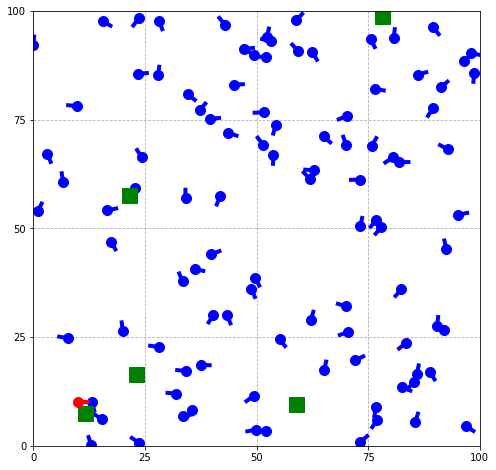

Error: [49.1, 2.93]
Weight Sum: 1.19
Max Weight: 0.15


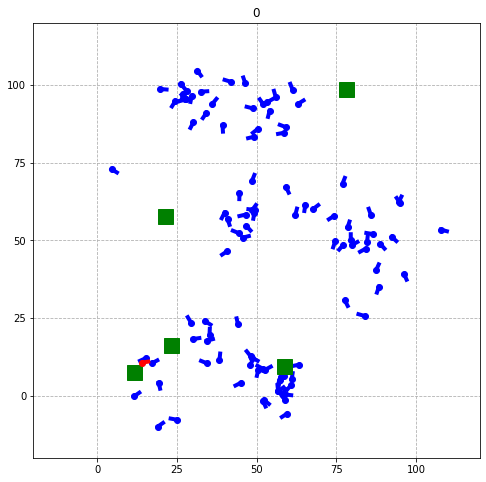

Error: [2.6, 0.4]
Weight Sum: 2.63
Max Weight: 0.54
Converged!


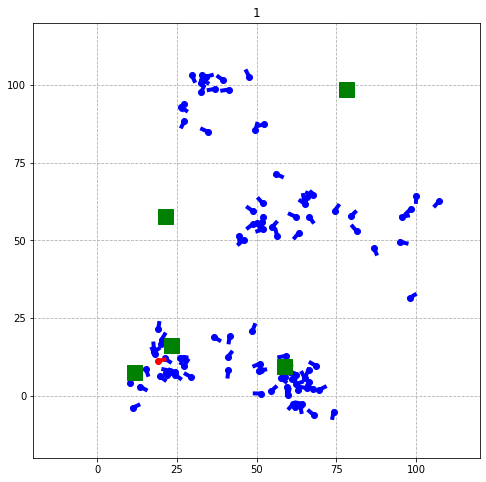

Error: [3.2, 0.19]
Weight Sum: 4.29
Max Weight: 0.71


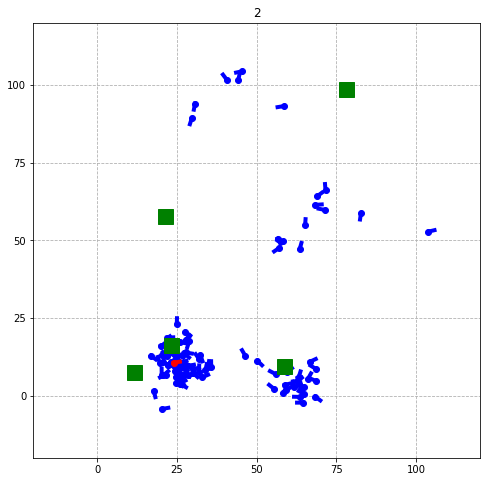

Error: [0.6, 0.16]
Weight Sum: 9.18
Max Weight: 0.89
Converged!


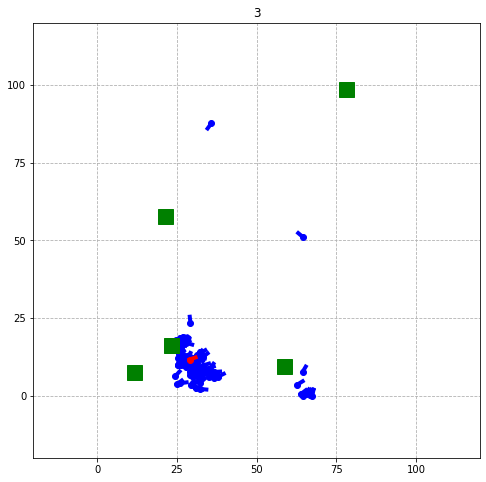

Error: [2.3, 0.0]
Weight Sum: 25.35
Max Weight: 0.93
Converged!


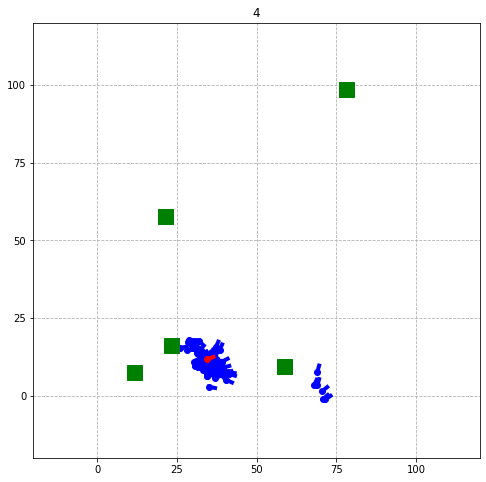

Error: [1.8, 0.07]
Weight Sum: 36.34
Max Weight: 0.93
Converged!


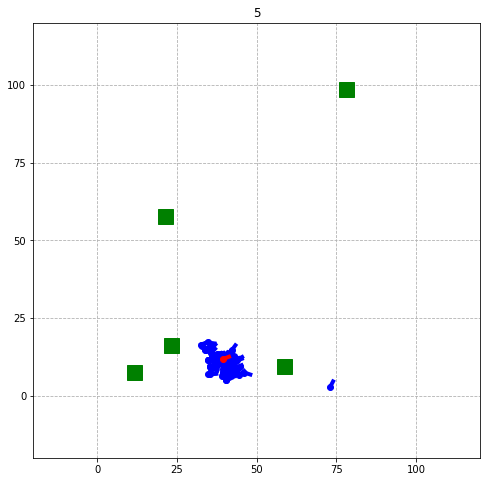

Error: [0.6, 0.0]
Weight Sum: 45.46
Max Weight: 1.0
Converged!


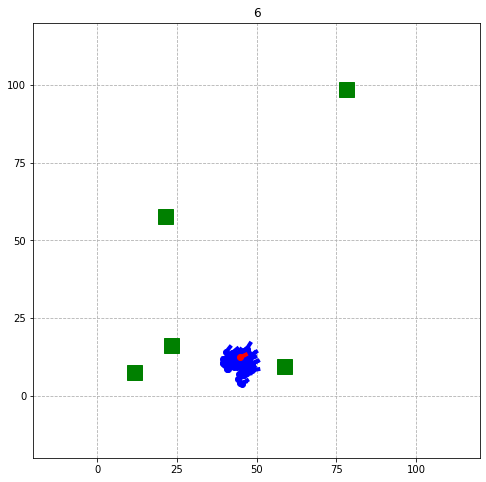

Error: [2.4, 0.08]
Weight Sum: 35.03
Max Weight: 0.91
Converged!


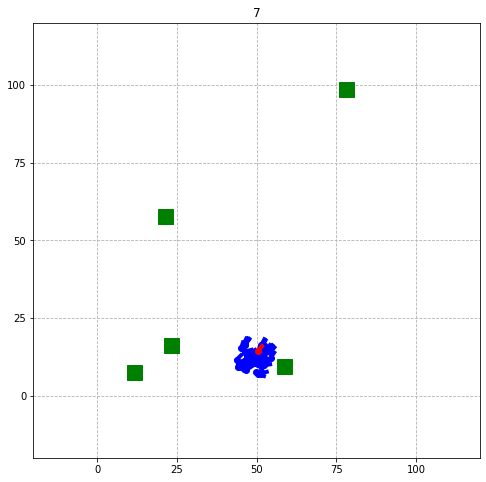

Error: [2.2, 0.05]
Weight Sum: 42.9
Max Weight: 0.9
Converged!


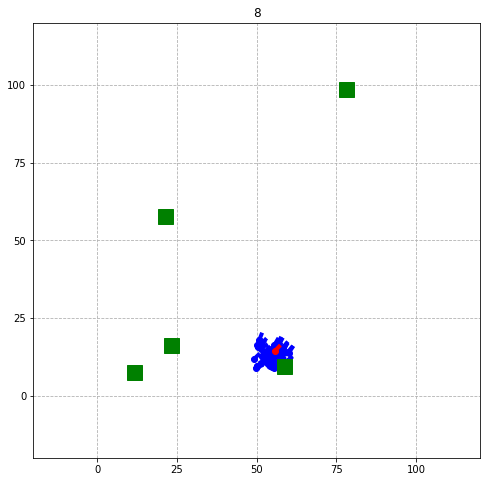

Error: [1.1, 0.08]
Weight Sum: 52.98
Max Weight: 0.97
Converged!


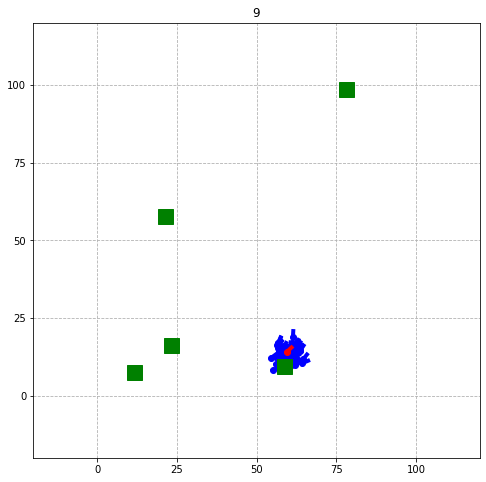

Error: [1.9, 0.03]
Weight Sum: 42.56
Max Weight: 0.94
Converged!


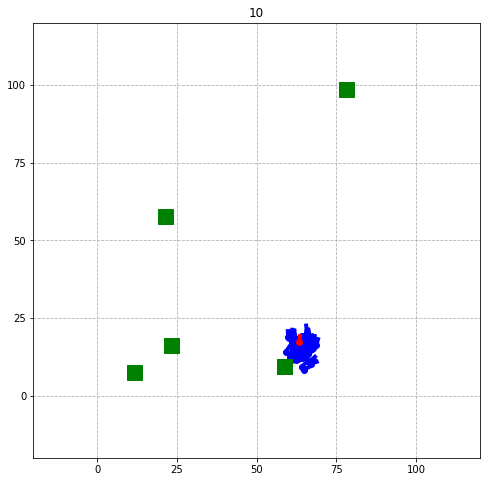

Error: [1.1, 0.03]
Weight Sum: 56.56
Max Weight: 0.98
Converged!


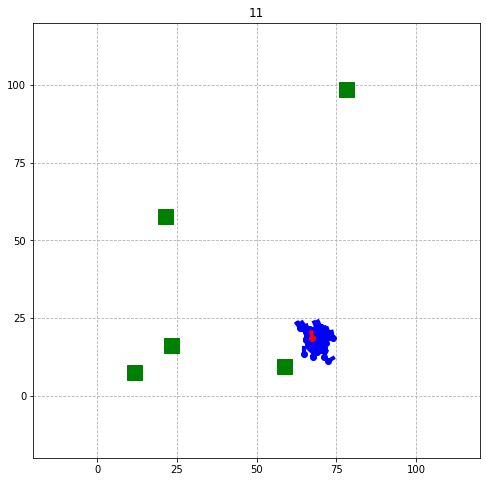

Error: [0.9, 0.06]
Weight Sum: 63.24
Max Weight: 0.98
Converged!


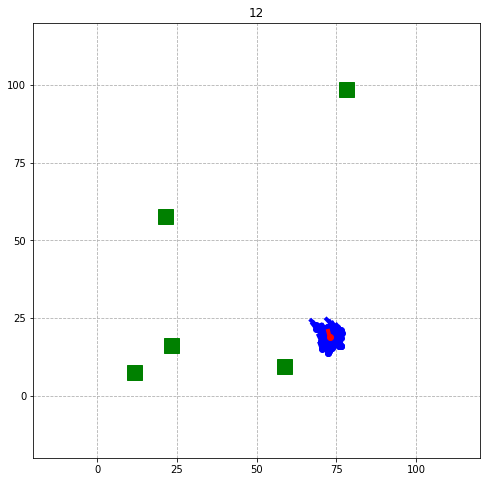

Error: [1.0, 0.01]
Weight Sum: 69.09
Max Weight: 0.99
Converged!


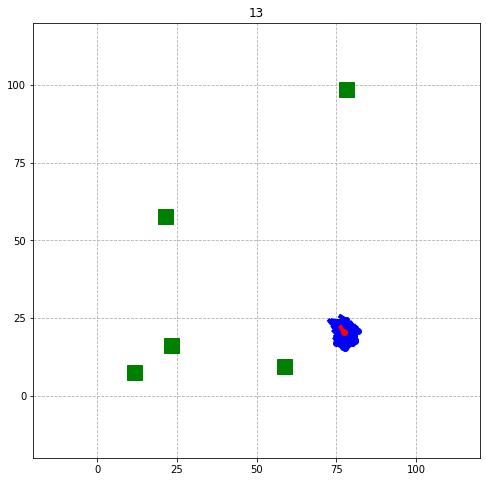

Error: [2.6, 0.03]
Weight Sum: 45.6
Max Weight: 0.92
Converged!


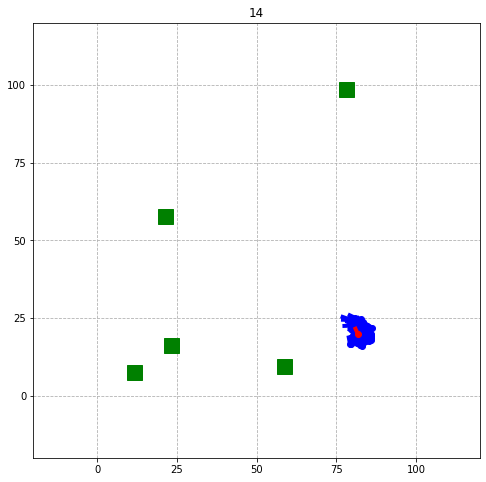

Error: [1.6, 0.04]
Weight Sum: 51.05
Max Weight: 0.96
Converged!


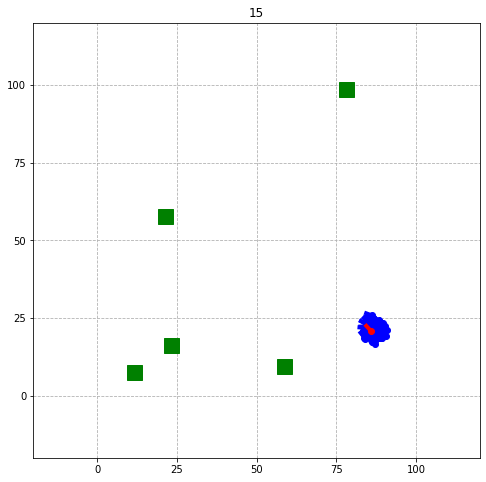

Error: [2.1, 0.04]
Weight Sum: 49.19
Max Weight: 0.96
Converged!


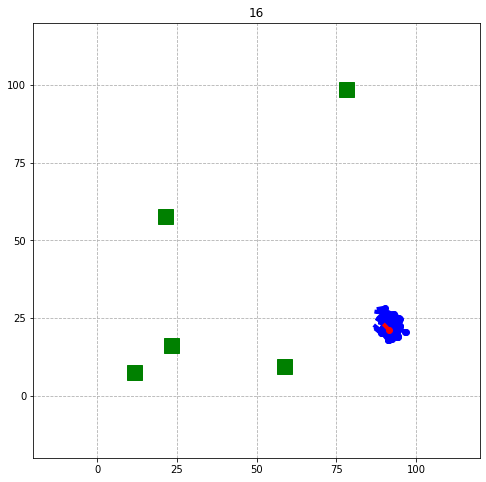

Error: [1.4, 0.05]
Weight Sum: 58.73
Max Weight: 0.98
Converged!


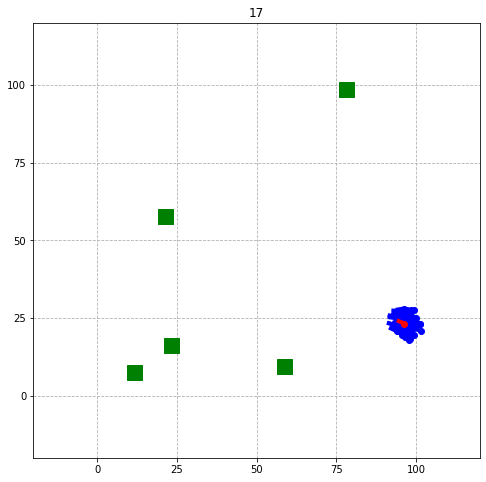

Error: [0.4, 0.0]
Weight Sum: 63.94
Max Weight: 0.99
Converged!


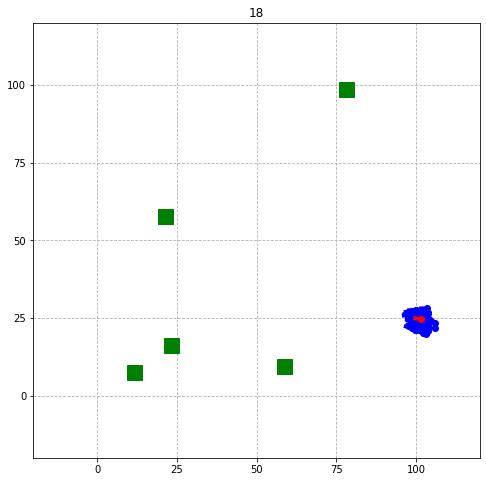

Error: [1.1, 0.02]
Weight Sum: 63.27
Max Weight: 0.99
Converged!


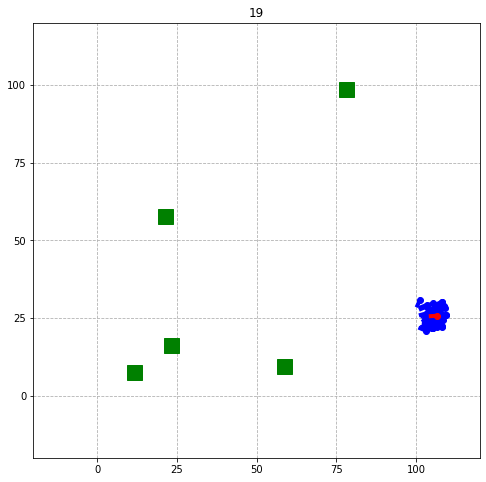

Error: [1.4, 0.02]
Weight Sum: 56.23
Max Weight: 0.98
Converged!


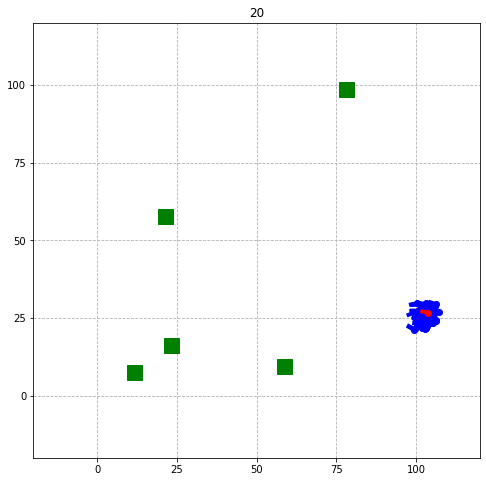

Error: [0.2, 0.06]
Weight Sum: 63.38
Max Weight: 0.99
Converged!


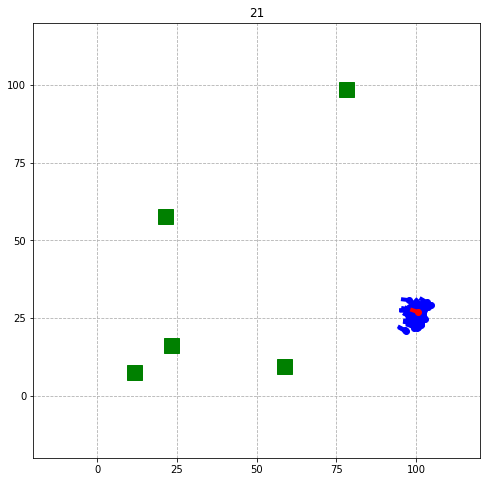

Error: [0.1, 0.09]
Weight Sum: 64.37
Max Weight: 0.97
Converged!


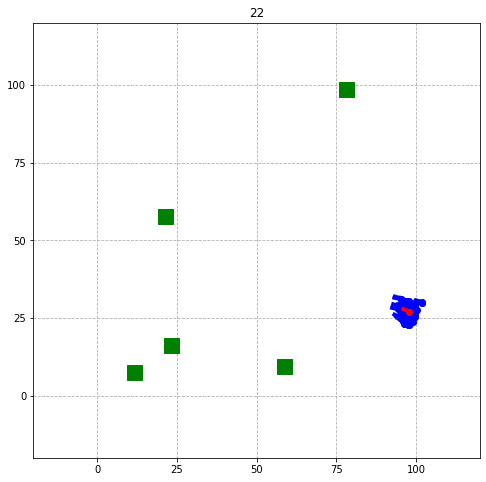

Error: [0.9, 0.01]
Weight Sum: 61.57
Max Weight: 0.99
Converged!


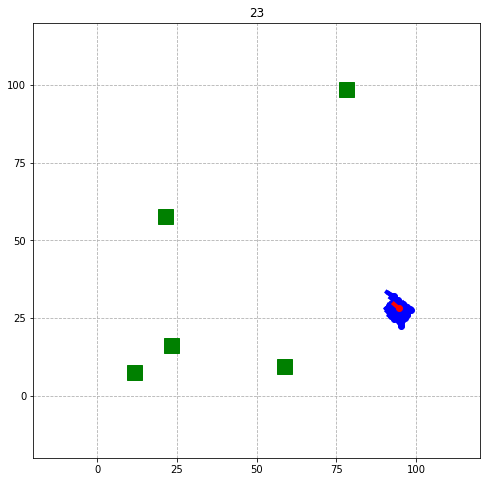

Error: [0.5, 0.02]
Weight Sum: 70.96
Max Weight: 1.0
Converged!


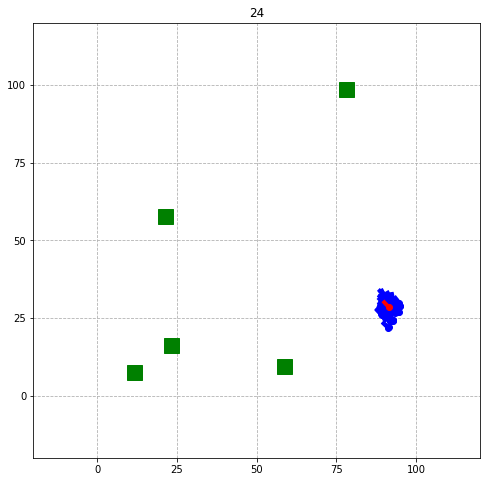

Error: [0.4, 0.03]
Weight Sum: 65.7
Max Weight: 0.99
Converged!


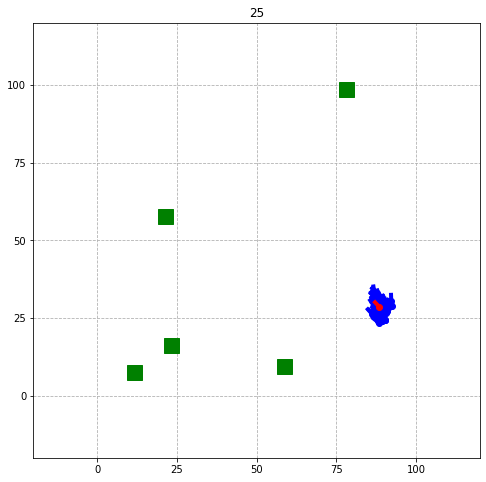

Error: [1.1, 0.09]
Weight Sum: 61.04
Max Weight: 0.95
Converged!


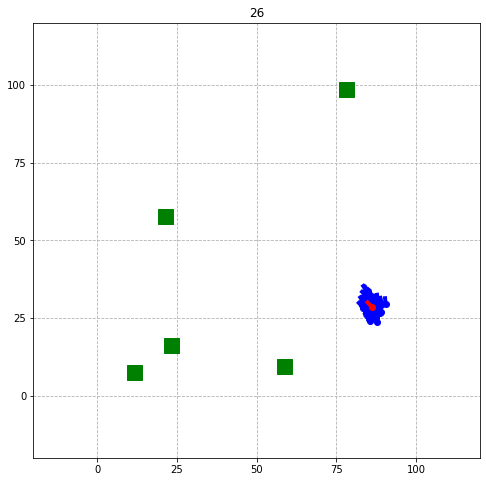

Error: [0.7, 0.07]
Weight Sum: 54.74
Max Weight: 0.97
Converged!


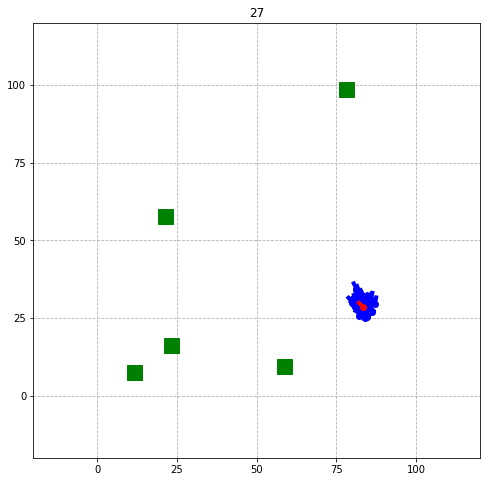

Error: [0.2, 0.07]
Weight Sum: 40.21
Max Weight: 0.98
Converged!


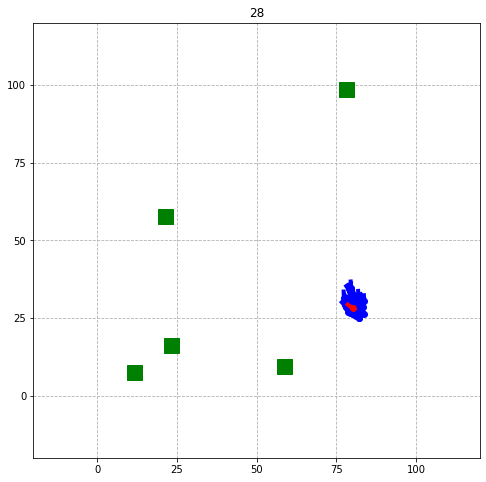

Error: [1.7, 0.01]
Weight Sum: 55.63
Max Weight: 0.96
Converged!


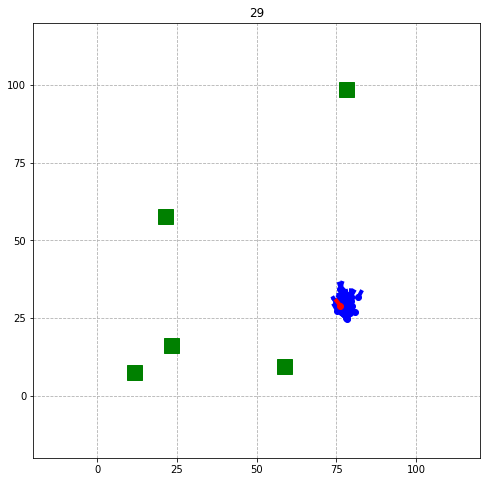

Error: [0.0, 0.01]
Weight Sum: 60.9
Max Weight: 1.0
Converged!


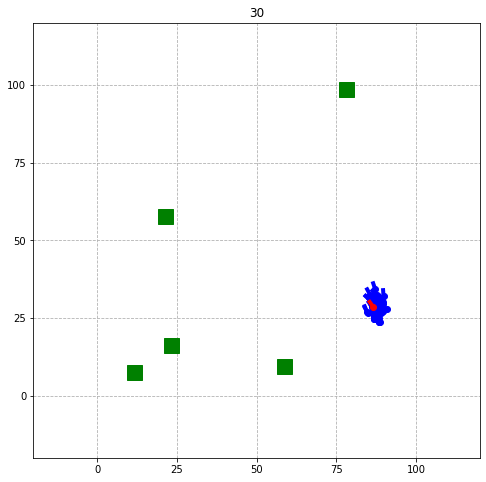

Error: [0.5, 0.02]
Weight Sum: 68.02
Max Weight: 0.99
Converged!


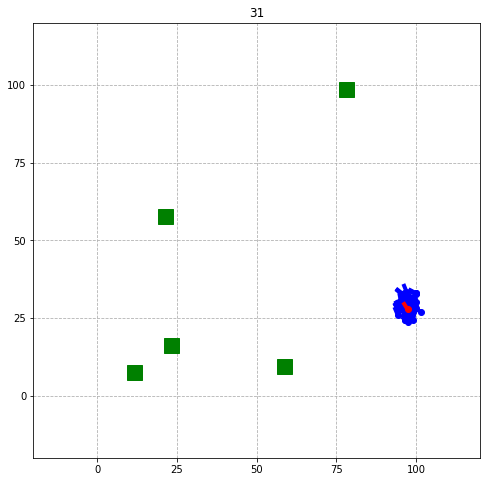

Error: [1.1, 0.01]
Weight Sum: 56.32
Max Weight: 0.99
Converged!


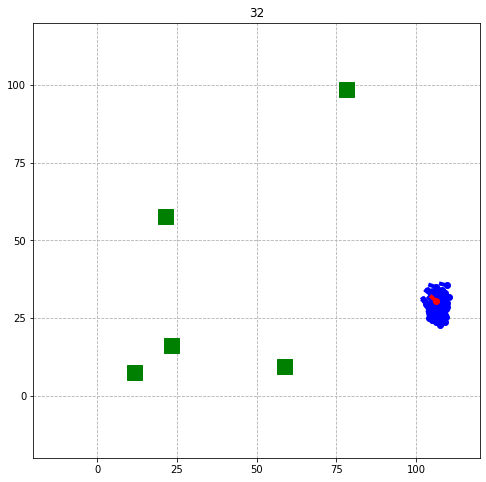

Error: [0.3, 0.01]
Weight Sum: 53.55
Max Weight: 1.0
Converged!


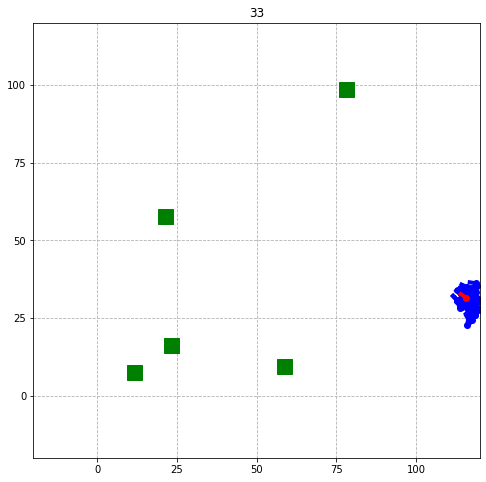

Error: [1.4, 0.02]
Weight Sum: 66.1
Max Weight: 0.98
Converged!


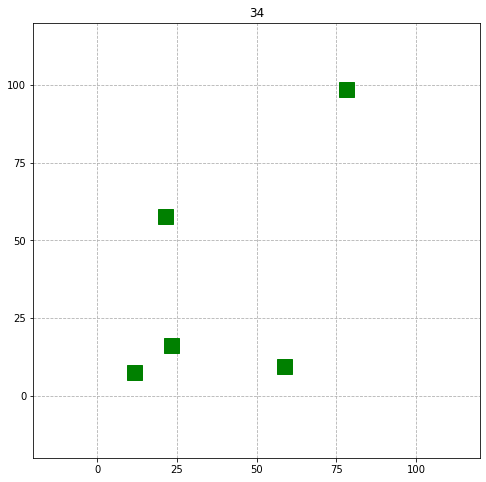

Error: [0.4, 0.08]
Weight Sum: 54.33
Max Weight: 0.97
Converged!


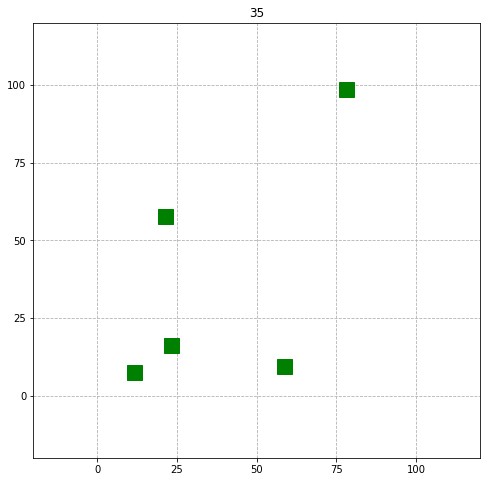

Error: [1.0, 0.07]
Weight Sum: 49.43
Max Weight: 0.94
Converged!


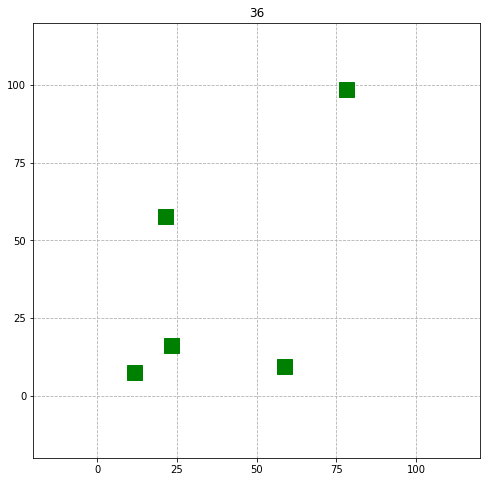

Error: [0.6, 0.04]
Weight Sum: 61.77
Max Weight: 0.98
Converged!


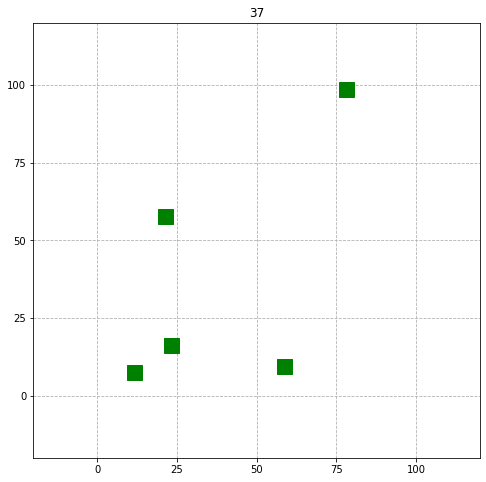

Error: [1.1, 0.05]
Weight Sum: 65.12
Max Weight: 0.98
Converged!


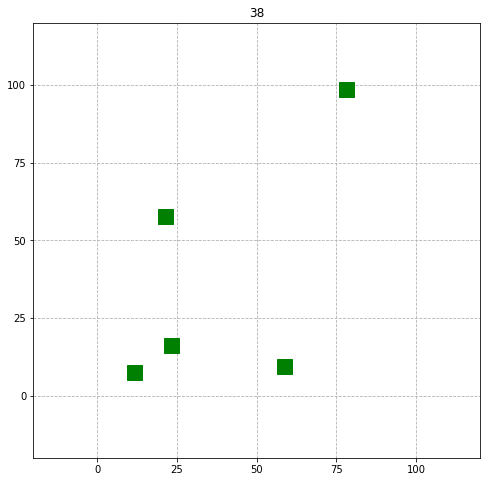

Error: [1.3, 0.02]
Weight Sum: 67.14
Max Weight: 0.98
Converged!


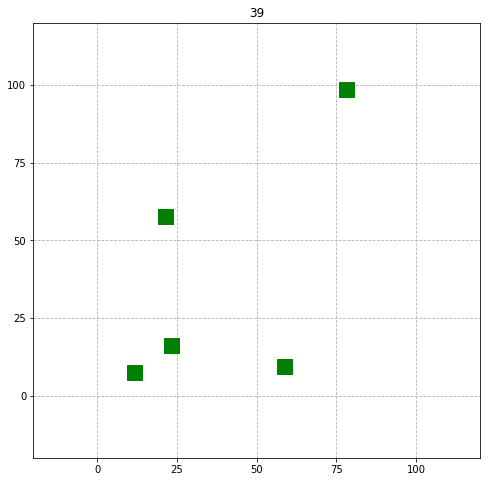

Error: [1.6, 0.03]
Weight Sum: 59.03
Max Weight: 0.99
Converged!


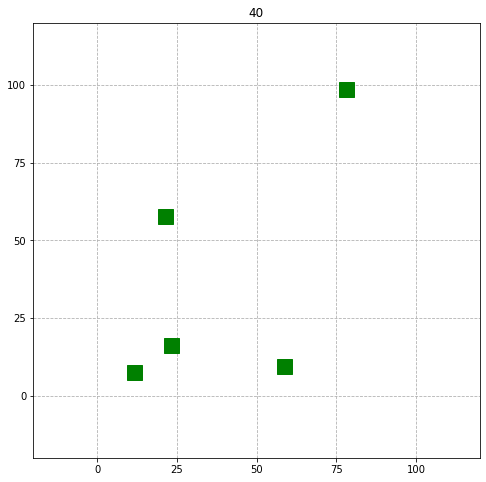

Error: [1.7, 0.03]
Weight Sum: 57.07
Max Weight: 0.98
Converged!


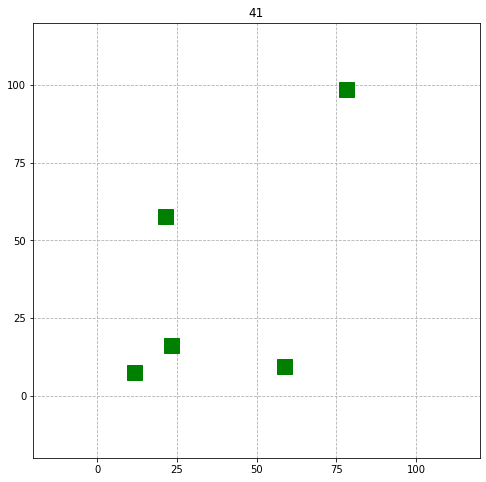

Error: [2.5, 0.01]
Weight Sum: 56.63
Max Weight: 0.97
Converged!


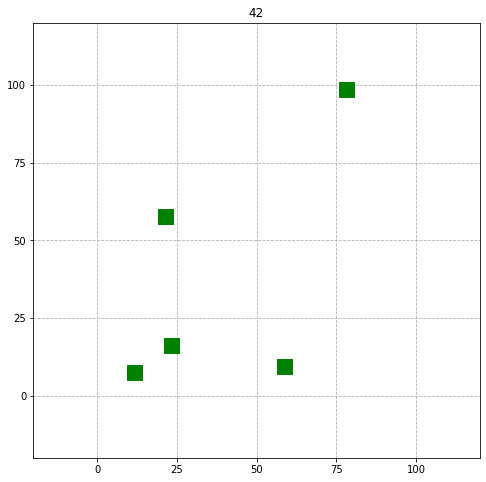

Error: [2.0, 0.03]
Weight Sum: 39.77
Max Weight: 0.93
Converged!


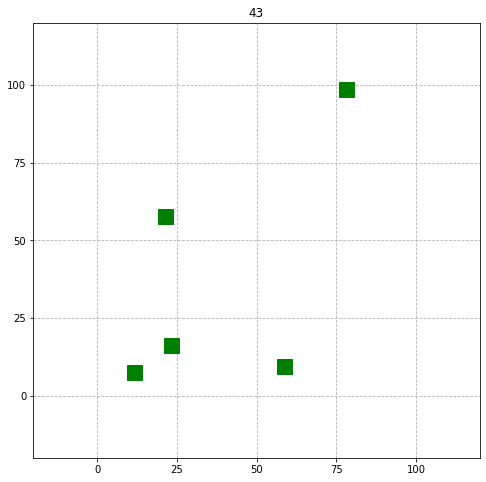

Error: [1.3, 0.03]
Weight Sum: 44.15
Max Weight: 0.97
Converged!


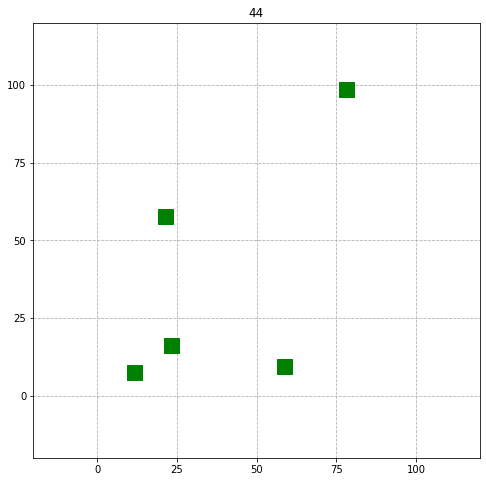

Error: [1.5, 0.04]
Weight Sum: 61.2
Max Weight: 0.97
Converged!


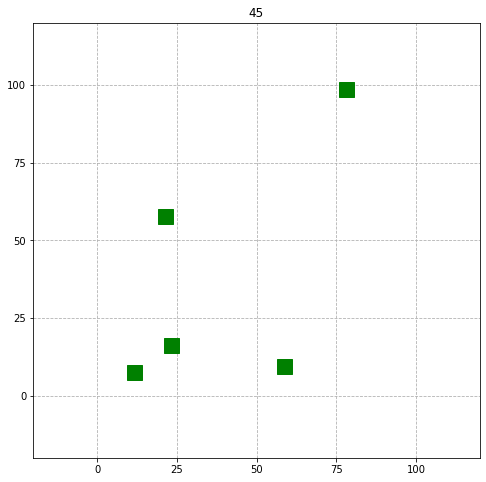

Error: [1.1, 0.01]
Weight Sum: 66.01
Max Weight: 1.0
Converged!


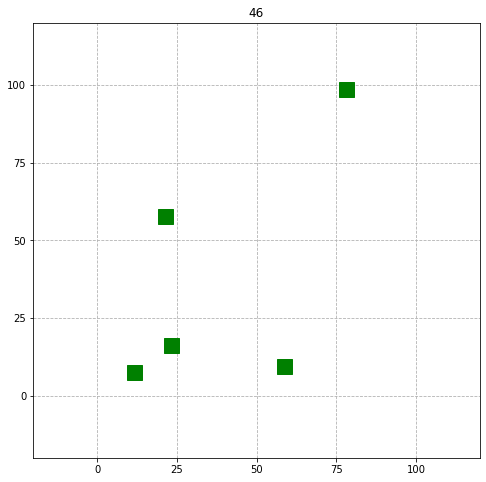

Error: [3.3, 0.04]
Weight Sum: 49.57
Max Weight: 0.94


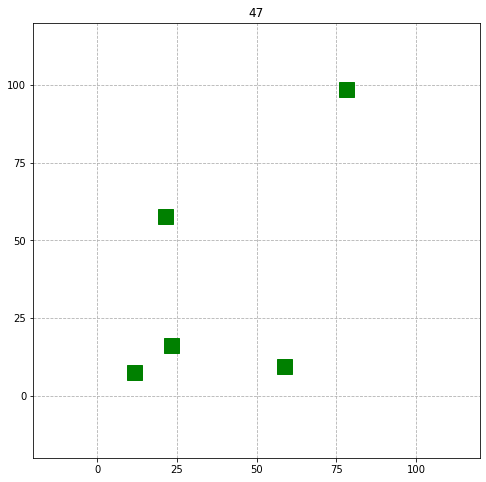

Error: [3.4, 0.01]
Weight Sum: 32.09
Max Weight: 0.92


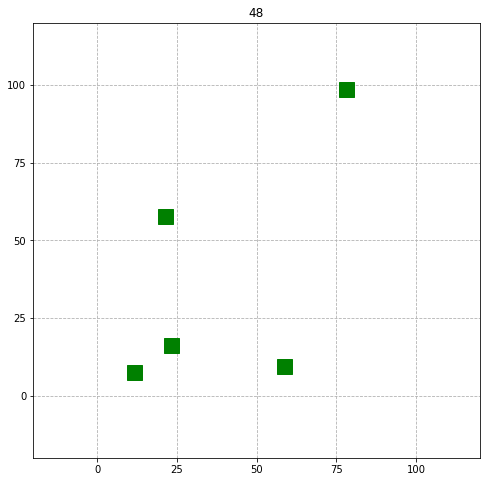

Error: [3.3, 0.02]
Weight Sum: 60.73
Max Weight: 0.97


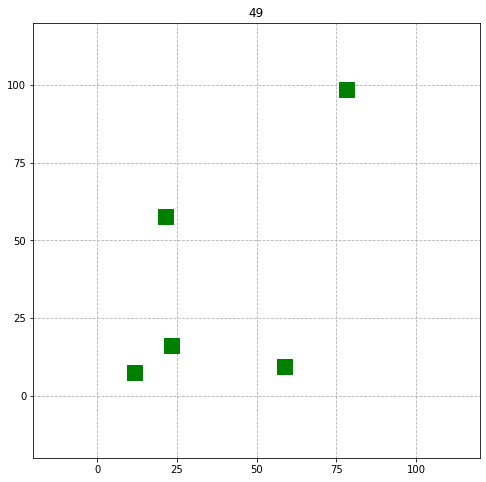

Error: [0.6, 0.06]
Weight Sum: 67.82
Max Weight: 0.98
Converged!


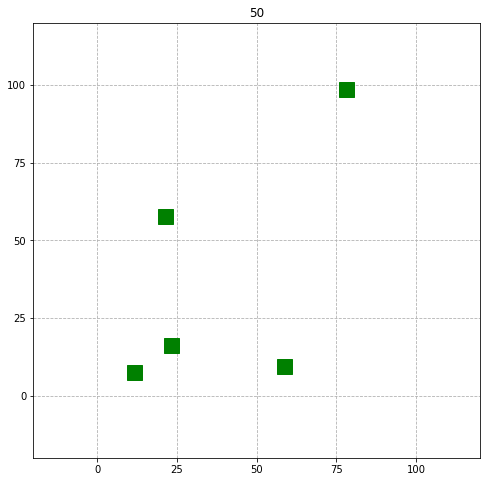

Error: [0.5, 0.0]
Weight Sum: 62.19
Max Weight: 1.0
Converged!


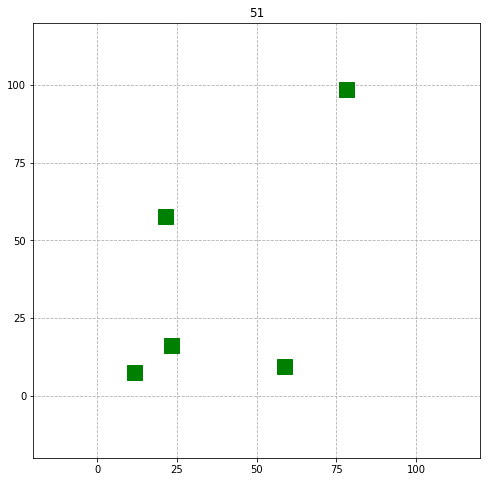

Error: [0.7, 0.01]
Weight Sum: 53.35
Max Weight: 1.0
Converged!


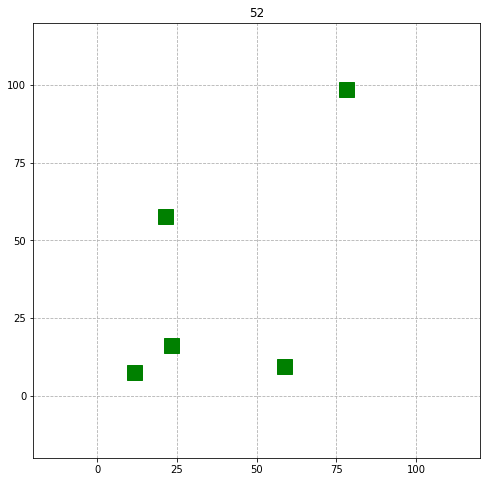

Error: [1.6, 0.03]
Weight Sum: 63.2
Max Weight: 0.99
Converged!


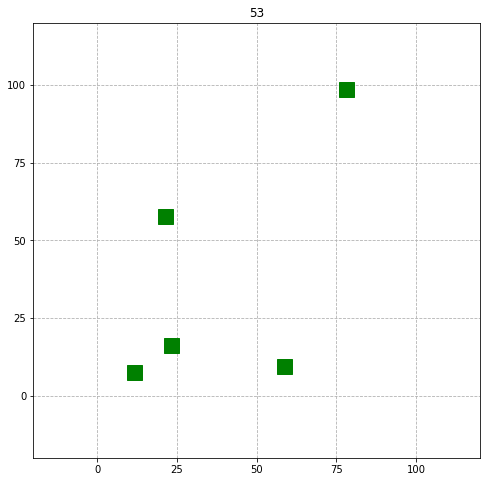

Error: [0.2, 0.05]
Weight Sum: 72.5
Max Weight: 0.99
Converged!


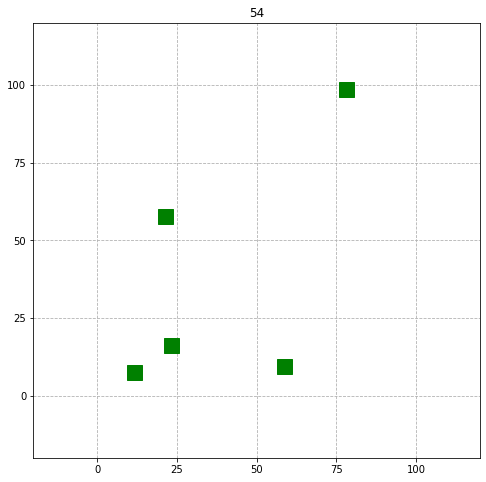

Error: [0.3, 0.04]
Weight Sum: 70.0
Max Weight: 0.99
Converged!


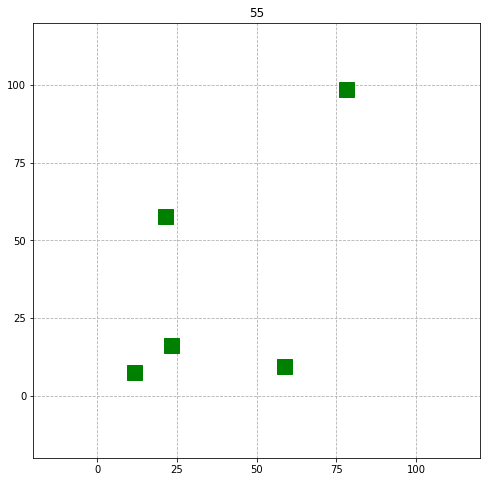

Error: [2.4, 0.07]
Weight Sum: 56.53
Max Weight: 0.97
Converged!


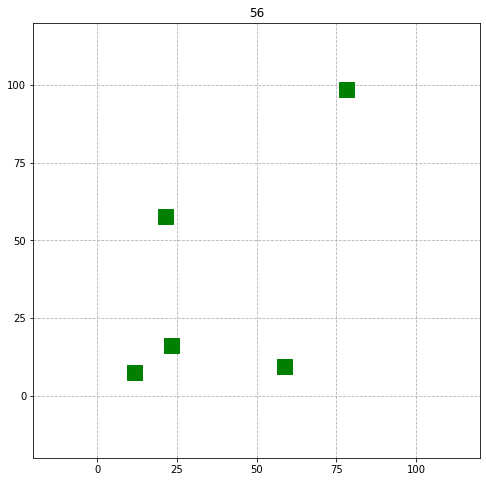

Error: [1.2, 0.26]
Weight Sum: 16.73
Max Weight: 0.75
Converged!


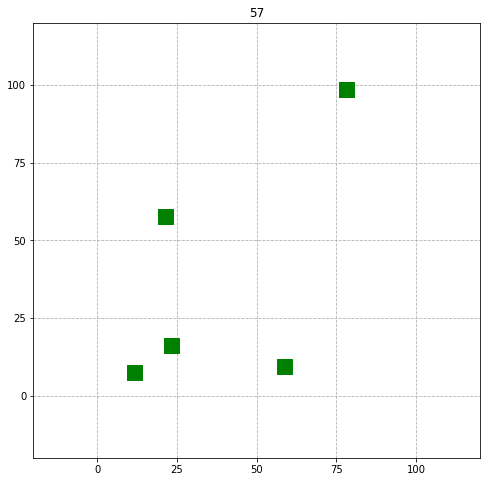

Error: [1.5, 0.0]
Weight Sum: 45.3
Max Weight: 0.99
Converged!


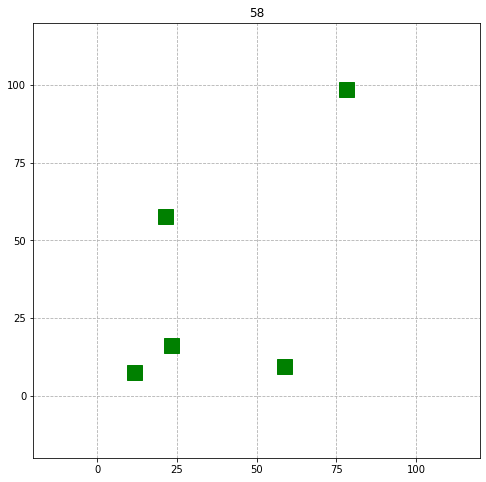

Error: [0.6, 0.01]
Weight Sum: 68.91
Max Weight: 1.0
Converged!


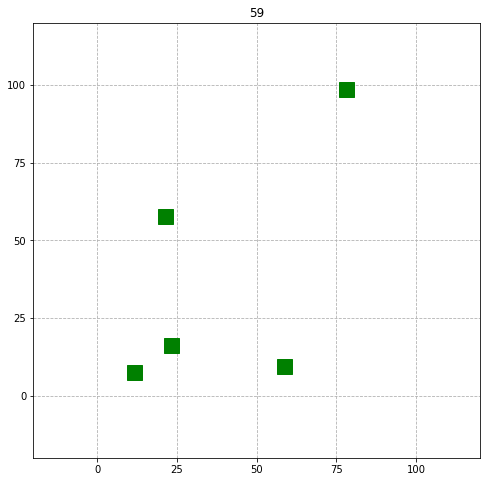

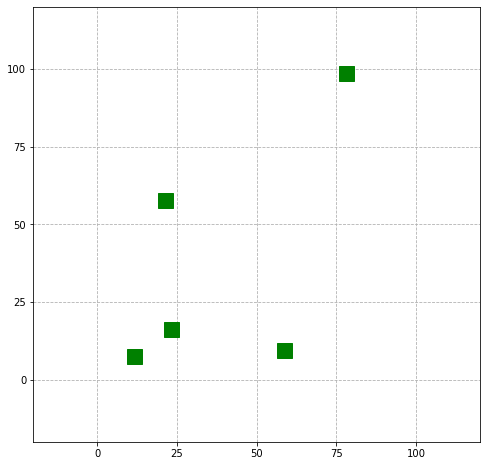

In [7]:
from sim.plot2d import plot, print_particle_error
import random as r
import math


# r.seed(939)
robot = Robot([10, 10, 0])
poles = []
num_poles = 5
for i in range(num_poles):
    x = r.uniform(0, 100)
    y = r.uniform(0, 100)
    poles += [Pole([x, y, 0])]
particles = []
num_particles = 100
for i in range(num_particles):
    x = r.uniform(0, 100)
    y = r.uniform(0, 100)
    theta = r.uniform(0, math.pi * 2)
    particles += [Particle([x, y, theta])]

plot(robot, particles, poles)


moves = []
for i in range(60):
    if i < 10:
        moves += [[5, 0]]
        continue
    if i < 20:
        moves += [[5, math.pi / 10]]
        continue
    if i < 30:
        moves += [[-3, -math.pi / 20]]
        continue
    if i < 35:
        moves += [[10, 0]]
        continue
    if i < 45:
        moves += [[2, -math.pi / 5]]
        continue
    if i < 55:
        moves += [[4, math.pi / 20]]
        continue

    moves += [[0, 0]]

for i in range(60):
    # Move Robot
    robot.move_with_error(moves[i][0], moves[i][1])  # add noise here
    robot.measure(poles)                 # and add noise here
    # Move and Update Particles
    for particle in particles:
        particle.predict(moves[i][0], moves[i][1])
        particle.measure(poles)
        particle.update_weight(robot.measurements)
    # Resample
    print_particle_error(robot, particles)
    particles = resample_particles(particles)
    plot(robot, particles, poles, j=i, autorun=True, time=0.5, error=True)
plot(robot, particles, poles, error=True)
